"There is a trade-off here: the longer the window length, the more these positive benefits
are realised; however if the window length becomes too large, the probability that a given window
contains more than one activity is increased, the delay before a classification output can be generated
is increased, and the number of training examples for the classifier will also be reduced.

Using a short window length enables near real-time
inference of the user’s current activity and ensures the detection can rapidly adapt to changes"

------------------------------------------
#**Notes:**


Tried :


- Resampled into even time space   
- Looked into HAR and how they used there filtering on accelometer - median , low pass 0.3 & 20hz  
- Calc row , yall & pitch   
- Rotate back to earth fixed frame 
- read in all data and resample everything to stop mess (cleaner mess notebook)
- some viz just to help see 
- introduce sliding window 



--------------------------------------

Handcrafted Features of Human Activity Recognition Dataset - they also performed a Fast Fourier Transform 

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

https://github.com/PankajKarki/Human-Activity-recognition


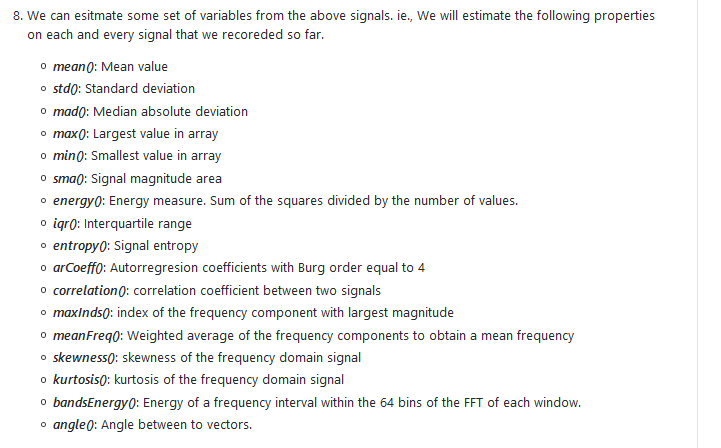

https://www.semanticscholar.org/paper/A-Public-Domain-Dataset-for-Human-Activity-using-Anguita-Ghio/83de43bc849ad3d9579ccf540e6fe566ef90a58e/figure/1

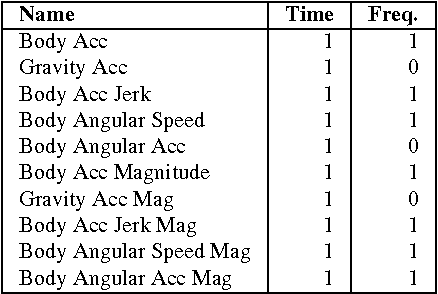

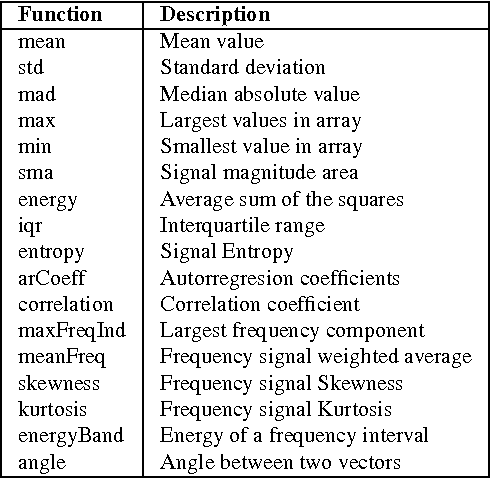

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 08-04-2015 04.08.05.482 - Right Coat Pocket - TrialFPSV3502 - True Orientation Data.csv to 08-04-2015 04.08.05.482 - Right Coat Pocket - TrialFPSV3502 - True Orientation Data.csv
Saving 08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv to 08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv
Saving 08-04-2015 04.08.05.545 - Right Coat Pocket - TrialFPSV3502 - Raw Magnetometer.csv to 08-04-2015 04.08.05.545 - Right Coat Pocket - TrialFPSV3502 - Raw Magnetometer.csv
Saving 08-04-2015 04.08.05.572 - Right Coat Pocket - TrialFPSV3502 - Raw Gyro.csv to 08-04-2015 04.08.05.572 - Right Coat Pocket - TrialFPSV3502 - Raw Gyro.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 08-04-2015 13.06.09.853 - TrialFPSV3502 - Markers.csv to 08-04-2015 13.06.09.853 - TrialFPSV3502 - Markers.csv


# Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime
import statistics

# Read in data

In [ ]:
raw_acc_1 = pd.read_csv("08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
len(raw_acc_1)

1849

In [ ]:
raw_acc_1.shape

(1849, 6)

In [ ]:
raw_acc_1.head()

,System Time (ms),Event Time (ns),X Axis,Y Axis,Z Axis,Unnamed: 5
0,1428494885758,2.774515e+11,-6.100115,-2.876119,7.323521,NaN
1,1428494885791,2.774615e+11,-6.219566,-2.746788,7.245683,NaN
2,1428494885793,2.774715e+11,-5.949977,-2.938539,7.375313,NaN
3,1428494885796,2.774815e+11,-6.266419,-2.756069,7.297475,NaN
4,1428494885799,2.774915e+11,-6.055358,-2.788551,7.098239,NaN


## Drop Unnamed col & System Time 

In [ ]:
raw_acc_1 = raw_acc_1.drop(['Unnamed: 5' , 'System Time (ms)'], axis=1)

In [ ]:
raw_acc_1.isna().sum()

Event Time (ns)    1
X Axis             1
Y Axis             1
Z Axis             1
dtype: int64

In [ ]:
raw_acc_1 = raw_acc_1.drop(1848)

In [ ]:
raw_acc_1.tail()

,Event Time (ns),X Axis,Y Axis,Z Axis
1843,2.958910e+11,-6.060597,-3.556754,6.900650
1844,2.959009e+11,-6.232889,-3.307073,7.030430
1845,2.959109e+11,-5.924829,-3.545078,6.728957
1846,2.959209e+11,-6.155649,-3.358266,6.583909
1847,2.959309e+11,-6.349047,-3.184029,7.048093


# Quick check of NA 

In [ ]:
raw_acc_1.isna().sum()

Event Time (ns)    0
X Axis             0
Y Axis             0
Z Axis             0
dtype: int64

# Check Data types 

In [ ]:
raw_acc_1.dtypes

Event Time (ns)    float64
X Axis             float64
Y Axis             float64
Z Axis             float64
dtype: object

# Convert dtype of Event Time (ns) to datetime so can resample

In [ ]:
raw_acc_1['Time']  =  pd.to_datetime(raw_acc_1['Event Time (ns)'], unit='ns')

# this will give zero days instead of a date 
#raw_acc_1['Time']  =  pd.to_timedelta(raw_acc_1['Event Time (ns)'], unit='ns')

In [ ]:
raw_acc_1.head(10)

,Event Time (ns),X Axis,Y Axis,Z Axis,Time
0,2.774515e+11,-6.100115,-2.876119,7.323521,1970-01-01 00:04:37.451507534
1,2.774615e+11,-6.219566,-2.746788,7.245683,1970-01-01 00:04:37.461486782
2,2.774715e+11,-5.949977,-2.938539,7.375313,1970-01-01 00:04:37.471496548
3,2.774815e+11,-6.266419,-2.756069,7.297475,1970-01-01 00:04:37.481475796
4,2.774915e+11,-6.055358,-2.788551,7.098239,1970-01-01 00:04:37.491485561
5,2.775015e+11,-6.041287,-2.699786,7.265292,1970-01-01 00:04:37.501464810
6,2.775115e+11,-6.189030,-2.863246,7.369774,1970-01-01 00:04:37.511474575
7,2.775215e+11,-6.363417,-2.733316,7.303762,1970-01-01 00:04:37.521453823
8,2.775315e+11,-6.051166,-2.720892,7.257657,1970-01-01 00:04:37.531463589
9,2.775414e+11,-6.228098,-2.937342,7.182364,1970-01-01 00:04:37.541442837


In [ ]:
raw_acc_1.dtypes

Event Time (ns)           float64
X Axis                    float64
Y Axis                    float64
Z Axis                    float64
Time               datetime64[ns]
dtype: object

# Now set Time column as the index

In [ ]:
raw_acc_1.set_index('Time' ,  inplace=True)

In [ ]:
raw_acc_1

,Event Time (ns),X Axis,Y Axis,Z Axis
Time,,,,
1970-01-01 00:04:37.451507534,2.774515e+11,-6.100115,-2.876119,7.323521
1970-01-01 00:04:37.461486782,2.774615e+11,-6.219566,-2.746788,7.245683
1970-01-01 00:04:37.471496548,2.774715e+11,-5.949977,-2.938539,7.375313
1970-01-01 00:04:37.481475796,2.774815e+11,-6.266419,-2.756069,7.297475
1970-01-01 00:04:37.491485561,2.774915e+11,-6.055358,-2.788551,7.098239
...,...,...,...,...
1970-01-01 00:04:55.890960659,2.958910e+11,-6.060597,-3.556754,6.900650
1970-01-01 00:04:55.900939907,2.959009e+11,-6.232889,-3.307073,7.030430
1970-01-01 00:04:55.910919155,2.959109e+11,-5.924829,-3.545078,6.728957


-------------------------------------------------------------------------------------

# Now resample time column to evenly space it out (phones not consistent)

In [ ]:
raw_acc_1_resampled  =  raw_acc_1.resample('10000000NS').bfill()

In [ ]:
raw_acc_1_resampled 

,Event Time (ns),X Axis,Y Axis,Z Axis
Time,,,,
1970-01-01 00:04:37.450,2.774515e+11,-6.100115,-2.876119,7.323521
1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683
1970-01-01 00:04:37.470,2.774715e+11,-5.949977,-2.938539,7.375313
1970-01-01 00:04:37.480,2.774815e+11,-6.266419,-2.756069,7.297475
1970-01-01 00:04:37.490,2.774915e+11,-6.055358,-2.788551,7.098239
...,...,...,...,...
1970-01-01 00:04:55.890,2.958910e+11,-6.060597,-3.556754,6.900650
1970-01-01 00:04:55.900,2.959009e+11,-6.232889,-3.307073,7.030430
1970-01-01 00:04:55.910,2.959109e+11,-5.924829,-3.545078,6.728957


# Just incase dont want it time as index

In [ ]:
df = raw_acc_1_resampled.reset_index()

df.head()

,Time,Event Time (ns),X Axis,Y Axis,Z Axis
0,1970-01-01 00:04:37.450,2.774515e+11,-6.100115,-2.876119,7.323521
1,1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683
2,1970-01-01 00:04:37.470,2.774715e+11,-5.949977,-2.938539,7.375313
3,1970-01-01 00:04:37.480,2.774815e+11,-6.266419,-2.756069,7.297475
4,1970-01-01 00:04:37.490,2.774915e+11,-6.055358,-2.788551,7.098239


------------------------

# Time difference

Hours : Mins : Seconds

so its 0.01 of a second, which is  $10^{-2}$ of a second 

In [ ]:
df.Time[1] - df.Time[0]

Timedelta('0 days 00:00:00.010000')

# Frequency 


1 occurance every 0.01 seconds    ->  F  = 1/0.01 = 100 hz 



In [ ]:
# imports 
import csv
import numpy as np
import math as m
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt


Going to copy HAR Preprocessing steps:

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

- Median filter 
- 3rd order low-pass Butterworth Filter with a 20 Hz cutoff Freq (This rate is sufficient for capturing humanbody motion since99%of its energy is contained below 15Hz) 
- The acceleration signal, which has gravitational and body motion components, was separated using an-other Butterworth low-pass filter into body acceleration and gravity.  The gravitationalforce is assumed to have only low frequency components, therefore we found from the experiments that 0.3 Hz was an optimal corner frequency for a constant gravity signal

https://link.springer.com/article/10.1007/s12652-018-1110-y

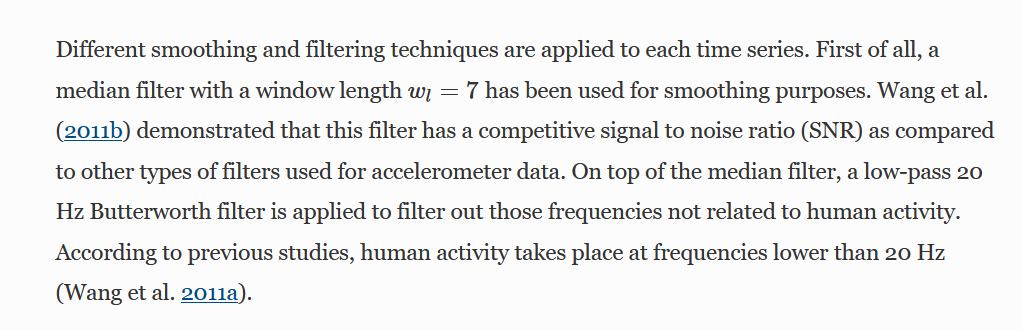

## Step 1: Median Filter 

In [ ]:
# Median Filter 

x1_median = signal.medfilt(raw_acc_1_resampled['X Axis'], kernel_size= 7)
y1_median = signal.medfilt(raw_acc_1_resampled['Y Axis'], kernel_size= 7)
z1_median = signal.medfilt(raw_acc_1_resampled['Z Axis'], kernel_size= 7)

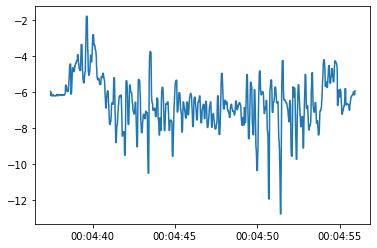

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median)
plt.show()

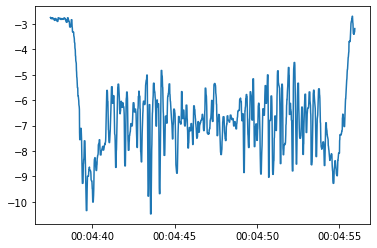

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median)
plt.show()

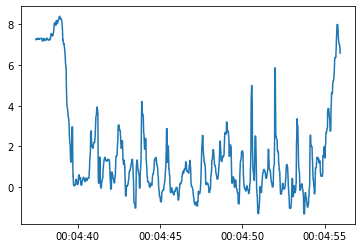

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median)
plt.show()

# Step 2: 3rd order low-pass Butterworth Filter with a 20 Hz cutoff Freq (This rate is sufficient for capturing human body motion since 99% of its energy is contained below 15Hz) 

In [ ]:
# Low Pass Filter body motion 

# sample frequecny
fs = 100
fc = 20

w = fc/(fs/2)
b,a = signal.butter(3, w, 'low')

x1_median_20hz = signal.filtfilt(b,a,x1_median)
y1_median_20hz = signal.filtfilt(b,a,y1_median)
z1_median_20hz = signal.filtfilt(b,a,z1_median)


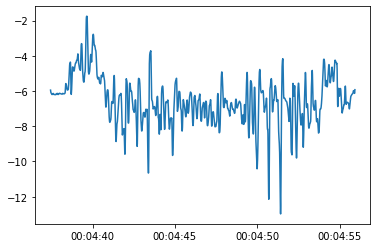

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz)
plt.show()

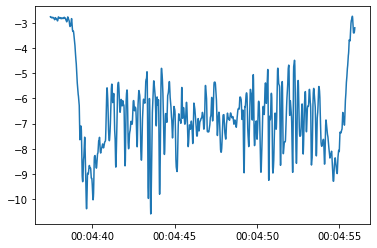

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz)
plt.show()

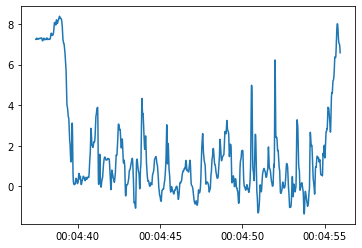

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz)
plt.show()

## Step 3: The acceleration signal, which has gravitational and body motion components, was separated using another Butterworth low-pass filter into body acceleration and gravity.  The gravitational force is assumed to have only low frequency components, therefore we found from the experiments that 0.3 Hz was an optimal corner frequency for a constant gravity signal

Efficient Human Activity Recognition Using a Single Wearable Sensor
https://ieeexplore.ieee.org/document/9097303



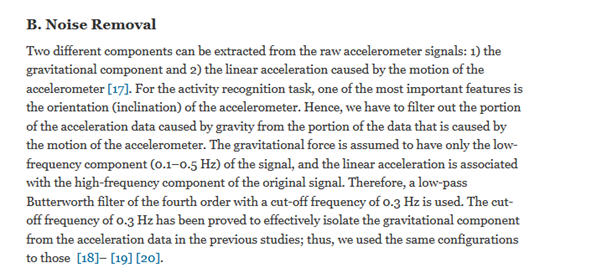

In [ ]:
# Low Pass Filter 

# sample frequecny
fs = 100

#Cut off frequency
fc = 0.3


w = fc/(fs/2)
b,a = signal.butter(4, w, 'low')

x1_median_20hz_gravity = signal.filtfilt(b,a,x1_median_20hz)
y1_median_20hz_gravity = signal.filtfilt(b,a,y1_median_20hz)
z1_median_20hz_gravity = signal.filtfilt(b,a,z1_median_20hz)


# x1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['X Axis'])
# y1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['Y Axis'])
# z1_median_20hz_gravity = signal.filtfilt(b,a,raw_acc_1_resampled['Z Axis'])


In [ ]:
x_squared = x1_median_20hz_gravity**2
y_squared = y1_median_20hz_gravity**2
z_squared = z1_median_20hz_gravity**2

total_squared = x_squared + y_squared  + z_squared


# want the mean of this to keep gravity constant throughout the trial 
value_total_acc = np.sqrt(np.mean(total_squared))

# calculating std 
std_total =  np.std(np.sqrt(total_squared))

diff =  value_total_acc - 9.81 

print(f"Mean force: {value_total_acc} ,  STD: {std_total} ,  Diff {diff}")

Mean force: 9.728206947179318 ,  STD: 0.16582423337327165 ,  Diff -0.08179305282068228


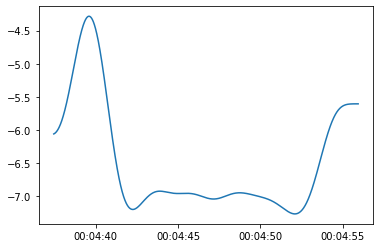

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz_gravity)
plt.show()

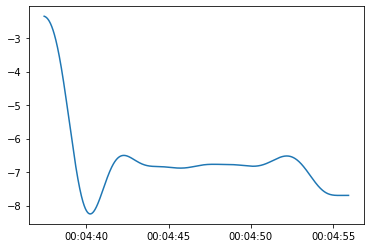

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz_gravity)
plt.show()

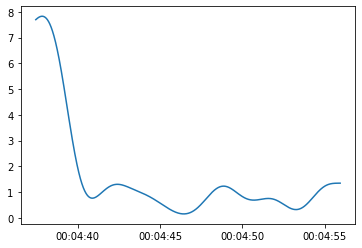

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz_gravity)
plt.show()

From their paper https://arxiv.org/ftp/arxiv/papers/1708/1708.08989.pdf

- their code was available on github and they substract gravity component from total to get movement 

https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs/blob/master/data/signal_filtering.py

In [ ]:
x1_median_20hz_movement = x1_median_20hz - x1_median_20hz_gravity
y1_median_20hz_movement = y1_median_20hz - y1_median_20hz_gravity
z1_median_20hz_movement = z1_median_20hz - z1_median_20hz_gravity

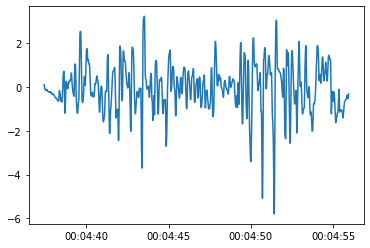

In [ ]:
plt.plot(raw_acc_1_resampled.index , x1_median_20hz_movement)
plt.show()

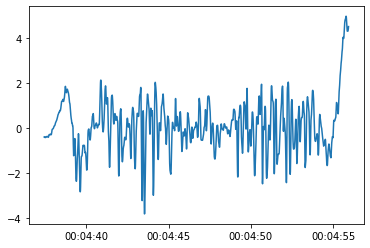

In [ ]:
plt.plot(raw_acc_1_resampled.index , y1_median_20hz_movement)
plt.show()

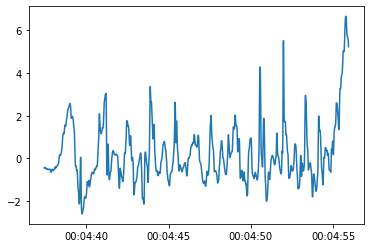

In [ ]:
plt.plot(raw_acc_1_resampled.index , z1_median_20hz_movement)
plt.show()

------------------------------------------------------------------

# Need to rotate from body fixed frame to earth fixed frame 

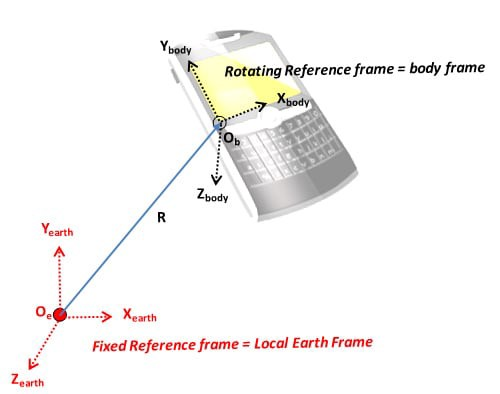-

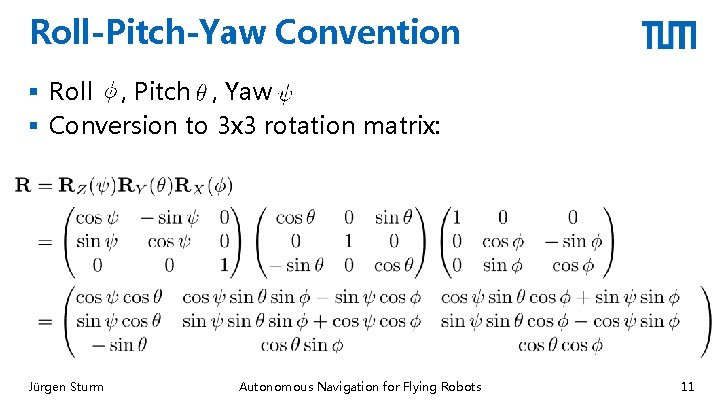

https://www.projectrhea.org/rhea/index.php/Accelerometer

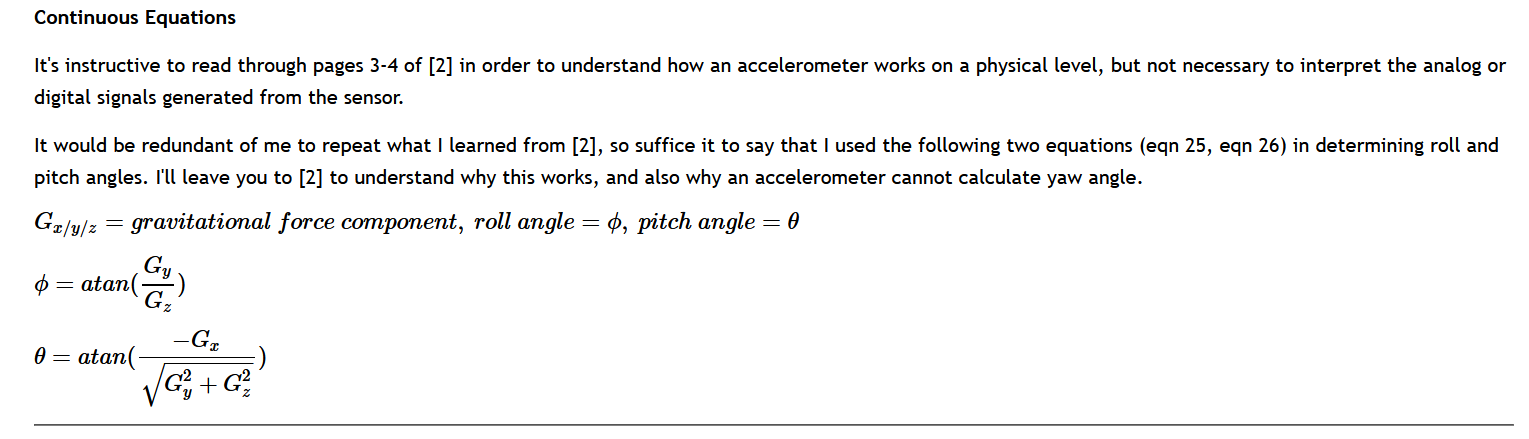

https://cdn.instructables.com/ORIG/F9L/9J61/JZX16QZA/F9L9J61JZX16QZA.pdf

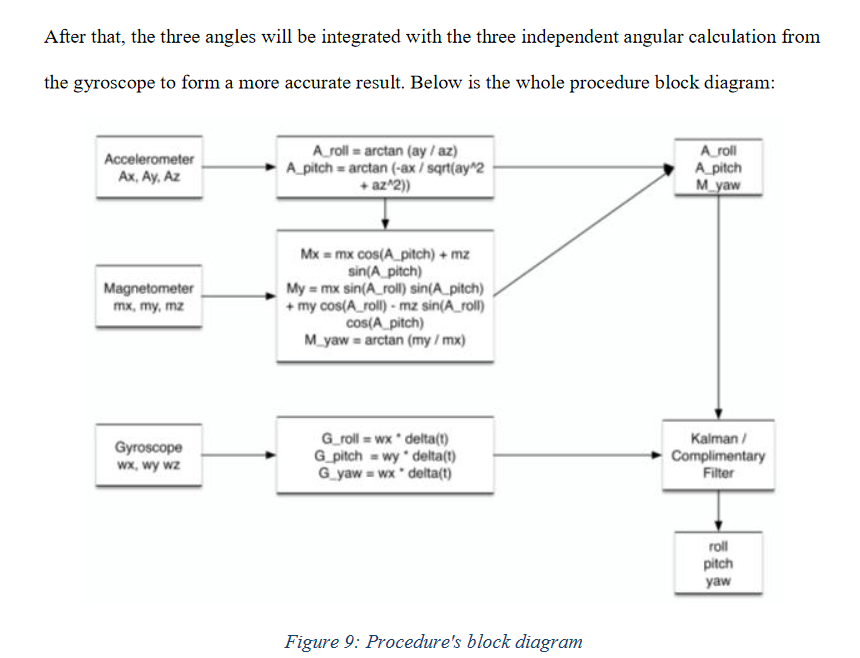



In [ ]:
#define angles for transfromation matrix

def Phi(y,z, degrees = False):

  "Calculates Roll Angle. If Degrees is set to true, the angles measurement is in degress and will be converted to radians."

  gy = y

  gz = z

  roll = gy / gz 

  if degrees == True:

    # convert degrees to radian 
    roll = math.radians(roll)

  return (m.atan(roll))


def Theta(x, y , z , degrees = False):

  "Calculate Pitch Angle"

  neg_gx = -x

  gy_square = y**2 
  gz_square = z**2

  pitch = neg_gx / ( np.sqrt(gy_square + gz_square))

  if degrees == True:

    # convert degrees to radian 
    pitch = m.radians(pitch)

  return (m.atan(pitch))
    

In [ ]:
pitch_1 = Theta( x1_median_20hz_gravity[0] , y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0] )

In [ ]:
roll_1 = Phi( y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0]  )

--------------------------------------------------------

# Read in Magnometer 

In [ ]:
raw_mag_1 = pd.read_csv("08-04-2015 04.08.05.545 - Right Coat Pocket - TrialFPSV3502 - Raw Magnetometer.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
raw_mag_1

,System Time (ms),Event Time (ns),X Axis,Y Axis,Z Axis,Unnamed: 5
0,1428494885761,2.774515e+11,32.104600,3.953857,-29.543610,NaN
1,1428494885791,2.774615e+11,32.104600,3.953857,-29.543610,NaN
2,1428494885794,2.774715e+11,32.104600,3.953857,-29.543610,NaN
3,1428494885797,2.774815e+11,32.304596,3.485306,-29.543610,NaN
4,1428494885800,2.774915e+11,32.304596,3.485306,-29.543610,NaN
...,...,...,...,...,...,...
1844,1428494904198,2.959009e+11,32.004593,6.882324,-29.626556,NaN
1845,1428494904210,2.959109e+11,32.504593,7.350891,-30.290192,NaN
1846,1428494904218,2.959209e+11,32.504593,7.350891,-30.290192,NaN
1847,1428494904228,2.959309e+11,32.504593,7.350891,-30.290192,NaN


In [ ]:
raw_mag_1['X Axis'].describe()

count    1848.000000
mean       31.440960
std         6.084774
min        17.104599
25%        25.504593
50%        32.854599
75%        35.704590
max        43.004593
Name: X Axis, dtype: float64

In [ ]:
raw_mag_1['Y Axis'].describe()

count    1848.000000
mean       38.302174
std        14.195285
min         3.485306
25%        33.707092
50%        37.806946
75%        50.106506
max        59.009033
Name: Y Axis, dtype: float64

In [ ]:
raw_mag_1['Z Axis'].describe()

count    1848.000000
mean       -9.451639
std        13.154724
min       -35.516327
25%       -19.008392
50%       -12.869766
75%         3.472214
max        14.422211
Name: Z Axis, dtype: float64

In [ ]:
raw_mag_1.shape

(1849, 6)

In [ ]:
raw_mag_1 = raw_mag_1.drop(1848)

In [ ]:
# now resample time 

raw_mag_1['Time']  =  pd.to_datetime(raw_mag_1['Event Time (ns)'], unit='ns')

raw_mag_1.set_index('Time' ,  inplace=True)

raw_mag_1_resampled  =  raw_mag_1.resample('10000000NS').bfill()

In [ ]:
raw_mag_1_resampled.shape

(1849, 6)

In [ ]:
raw_mag_1.isna().sum()

System Time (ms)       0
Event Time (ns)        0
X Axis                 0
Y Axis                 0
Z Axis                 0
Unnamed: 5          1848
dtype: int64

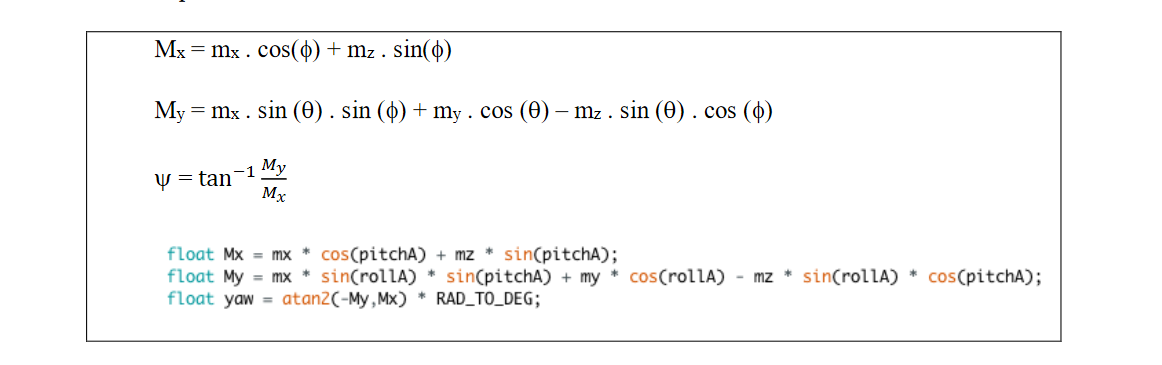



where swap roll & pitch from above , as in this paper they defined: 

- roll = theta 
- pitch = phi 
- yaw = psi 

**Where as have used so far:** 

- pitch = theta 
- roll = phi
- yaw = psi

In [ ]:
# Mx 
def psi(x_mag , y_mag , z_mag , roll , pitch ):

  x = x_mag 
  y = y_mag 
  z = z_mag

  roll = roll 
  pitch = pitch 

  Mx = x * m.cos(roll_1) + z * m.sin(roll_1)  

  My = x * m.sin(pitch_1) * m.sin(roll_1)  \
     + y * m.cos(pitch_1)                  \
     - z * m.sin(pitch_1) * m.cos(roll_1)


  yaw = m.atan(My / Mx)

  return yaw


In [ ]:
yaw_1 = psi(raw_mag_1['X Axis'][0] , raw_mag_1['Y Axis'][0] , raw_mag_1['Z Axis'][0] , roll = roll_1 , pitch= pitch_1)

In [ ]:
print(yaw_1)

0.3535861336216912


In [ ]:
print(f'Roll (phi): {roll_1}')
print(f'Pitch (theta): {pitch_1}')
print(f'Yaw (psi): {yaw_1}')

Roll (phi): -0.2962257578092806
Pitch (theta): 0.6452795052407627
Yaw (psi): 0.3535861336216912


----------------------------

# Preprocess stuff for kalman if needed

https://towardsdatascience.com/sensor-fusion-part-2-kalman-filter-code-78b82c63dcd


https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html


https://pykalman.github.io/

### Read in Gyro 

In [ ]:
# need to read in gyro measurements 
raw_gyro_1 = pd.read_csv("08-04-2015 04.08.05.572 - Right Coat Pocket - TrialFPSV3502 - Raw Gyro.csv" , 
                        skiprows=0 ,  header=1 )
raw_gyro_1

,System Time (ms),Event Time (ns),Pitch,Roll,Yaw,Unnamed: 5
0,1428494885751,2.774515e+11,0.005329,-0.047964,0.004263,NaN
1,1428494885790,2.774615e+11,0.003197,-0.047964,0.004263,NaN
2,1428494885793,2.774715e+11,0.003197,-0.047964,0.006395,NaN
3,1428494885795,2.774815e+11,0.002132,-0.049029,0.005329,NaN
4,1428494885798,2.774915e+11,0.004263,-0.049029,0.005329,NaN
...,...,...,...,...,...,...
1844,1428494904197,2.959009e+11,-0.306965,-0.125771,0.020251,NaN
1845,1428494904209,2.959109e+11,-0.246212,-0.077807,-0.036239,NaN
1846,1428494904217,2.959209e+11,-0.170537,0.020251,-0.114046,NaN
1847,1428494904227,2.959309e+11,-0.108717,0.091663,-0.131100,NaN


In [ ]:
# drop last row 

raw_gyro_1 = raw_gyro_1.drop(1848)

# now resample time 

raw_gyro_1['Time']  =  pd.to_datetime(raw_gyro_1['Event Time (ns)'], unit='ns')

raw_gyro_1.set_index('Time' ,  inplace=True)

raw_gyro_1_resampled  =  raw_gyro_1.resample('10000000NS').bfill()

In [ ]:
###########

raw_gyro_1_resampled

,System Time (ms),Event Time (ns),Pitch,Roll,Yaw,Unnamed: 5
Time,,,,,,
1970-01-01 00:04:37.450,1428494885751,2.774515e+11,0.005329,-0.047964,0.004263,NaN
1970-01-01 00:04:37.460,1428494885790,2.774615e+11,0.003197,-0.047964,0.004263,NaN
1970-01-01 00:04:37.470,1428494885793,2.774715e+11,0.003197,-0.047964,0.006395,NaN
1970-01-01 00:04:37.480,1428494885795,2.774815e+11,0.002132,-0.049029,0.005329,NaN
1970-01-01 00:04:37.490,1428494885798,2.774915e+11,0.004263,-0.049029,0.005329,NaN
...,...,...,...,...,...,...
1970-01-01 00:04:55.890,1428494904187,2.958910e+11,-0.335743,-0.146022,0.068214,NaN
1970-01-01 00:04:55.900,1428494904197,2.959009e+11,-0.306965,-0.125771,0.020251,NaN
1970-01-01 00:04:55.910,1428494904209,2.959109e+11,-0.246212,-0.077807,-0.036239,NaN


In [ ]:
# wx , wy , wz  * delta(t)

raw_gyro_1_resampled['G_Roll'] = raw_gyro_1_resampled['Roll'] * (0.01)
raw_gyro_1_resampled['G_Pitch'] = raw_gyro_1_resampled['Pitch'] * (0.01)
raw_gyro_1_resampled['G_Yaw'] = raw_gyro_1_resampled['Yaw'] * (0.01)

In [ ]:
raw_gyro_1_resampled

,System Time (ms),Event Time (ns),Pitch,Roll,Yaw,Unnamed: 5,G_Roll,G_Pitch,G_Yaw
Time,,,,,,,,,
1970-01-01 00:04:37.450,1428494885751,2.774515e+11,0.005329,-0.047964,0.004263,NaN,-0.000480,0.000053,0.000043
1970-01-01 00:04:37.460,1428494885790,2.774615e+11,0.003197,-0.047964,0.004263,NaN,-0.000480,0.000032,0.000043
1970-01-01 00:04:37.470,1428494885793,2.774715e+11,0.003197,-0.047964,0.006395,NaN,-0.000480,0.000032,0.000064
1970-01-01 00:04:37.480,1428494885795,2.774815e+11,0.002132,-0.049029,0.005329,NaN,-0.000490,0.000021,0.000053
1970-01-01 00:04:37.490,1428494885798,2.774915e+11,0.004263,-0.049029,0.005329,NaN,-0.000490,0.000043,0.000053
...,...,...,...,...,...,...,...,...,...
1970-01-01 00:04:55.890,1428494904187,2.958910e+11,-0.335743,-0.146022,0.068214,NaN,-0.001460,-0.003357,0.000682
1970-01-01 00:04:55.900,1428494904197,2.959009e+11,-0.306965,-0.125771,0.020251,NaN,-0.001258,-0.003070,0.000203
1970-01-01 00:04:55.910,1428494904209,2.959109e+11,-0.246212,-0.077807,-0.036239,NaN,-0.000778,-0.002462,-0.000362


-------------------------------------------------------------------

In [ ]:
print(f'Roll (phi): {roll_1}')
print(f'Pitch (theta): {pitch_1}')
print(f'Yaw (psi): {yaw_1}')

Roll (phi): -0.2962257578092806
Pitch (theta): 0.6452795052407627
Yaw (psi): 0.3535861336216912


--------------------

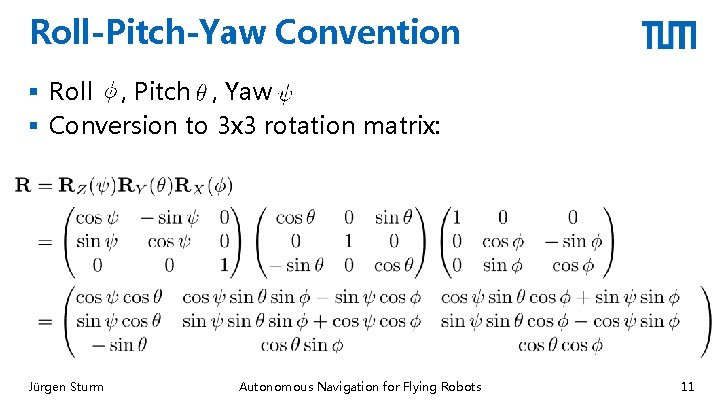

In [ ]:

#define the x column of the rotation matrix

def Rx(phi):
    return np.matrix([[1,                  0,                       0], 
                      [0,               m.cos(phi),    -m.sin(phi)],
                      [0,               m.sin(phi),    m.cos(phi)]])

def Ry(theta):
    return np.matrix([[m.cos(theta),      0            , m.sin(theta)],
                      [0                 ,1                        ,0],
                      [-m.sin(theta),     0,             m.cos(theta)]])

def Rz(psi):
    return np.matrix([[m.cos(psi),     -m.sin(psi) ,            0],
                      [m.sin(psi)   ,   m.cos(psi) ,            0],
                      [0 ,                    0,                1]])

Rotational stuff 

In [ ]:
#Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)


print(R1)

[[ 0.74950738 -0.49588446  0.43856275]
 [ 0.27664153  0.83648546  0.4730344 ]
 [-0.60142177 -0.2332181   0.76413427]]


In [ ]:
#Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
R1_1 = Rz(yaw_1+1) * Ry(pitch_1) * Rx(roll_1)


print(R1_1)

[[ 0.17217474 -0.97180576 -0.16108825]
 [ 0.78015878  0.03468264  0.6246194 ]
 [-0.60142177 -0.2332181   0.76413427]]


----------------------------------------

In [ ]:
array_test = [ [x1_median_20hz_gravity[0]] , [y1_median_20hz_gravity[0]] ,  [z1_median_20hz_gravity[0]] ]

In [ ]:
print( array_test[0] , array_test[1] , array_test[2] )

[-6.058662142424325] [-2.3494155894617506] [7.697811407666086]


In [ ]:
array_test

[[-6.058662142424325], [-2.3494155894617506], [7.697811407666086]]

In [ ]:
rot_x , rot_y , rot_z = R1 * array_test

In [ ]:
rot_x

matrix([[-9.84177409e-16]])

In [ ]:
rot_x = rot_x.astype(float)

In [ ]:
rot_y

matrix([[-1.89491588e-16]])

In [ ]:
rot_z

matrix([[10.073899]])

-------------------------------------------

So phone isnt constant througout test , as this should be approx constant 0

In [ ]:
arr_x , arr_y , arr_z = R1 * [ x1_median_20hz_gravity , y1_median_20hz_gravity ,  z1_median_20hz_gravity]

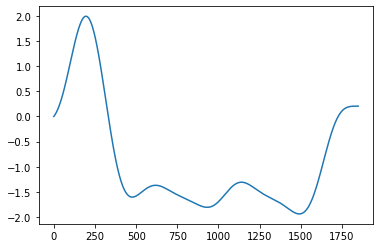

In [ ]:
ar_x = np.array(arr_x)

ar_x_s = np.squeeze(ar_x)

plt.plot(ar_x_s)
plt.show()

----------------------------------------------

In [ ]:
raw_gyro_1_resampled.shape

(1849, 9)

In [ ]:
raw_acc_1_resampled.shape

(1849, 4)

In [ ]:
raw_mag_1_resampled.shape

(1849, 6)

# now check entire thing 

# Since we extracted the gravity part alone (not fully it seems?) we should have approx constant 0 on x & y  and roughly 9.8 on z 

In [ ]:
# Now repeat for each stage 

x_rotted = [] 
y_rotted = [] 
z_rotted = [] 

x_move_rotted = [] 
y_move_rotted = [] 
z_move_rotted = [] 


for i in range(len(x1_median_20hz_gravity)):

  # Uses Acc
  pitch_1 = Theta( x1_median_20hz_gravity[i] , y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i] )
  roll_1 = Phi( y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i]  )

  x_mag = raw_mag_1_resampled['X Axis'][i]
  y_mag = raw_mag_1_resampled['Y Axis'][i]
  z_mag = raw_mag_1_resampled['Z Axis'][i]

  # uses Mag 
  yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)

  # put into array for multiplication 
  array_test = [ [x1_median_20hz_gravity[i]] , [y1_median_20hz_gravity[i]] ,  [z1_median_20hz_gravity[i]] ]

  # put movement acc into array for multiplication 
  array_test_move = [ [x1_median_20hz_movement[i]] , [y1_median_20hz_movement[i]] ,  [z1_median_20hz_movement[i]] ]

  # rotated values 
  rot_x , rot_y , rot_z = R1 * array_test


  # rotated values 
  rot_x_move , rot_y_move , rot_z_move = R1 * array_test_move

  # append 
  x_rotted.append(rot_x)
  y_rotted.append(rot_y)
  z_rotted.append(rot_z)


  # append 
  x_move_rotted.append(rot_x_move)
  y_move_rotted.append(rot_y_move)
  z_move_rotted.append(rot_z_move)


In [ ]:
arr_x_rotted = np.array(x_rotted)
arr_y_rotted = np.array(y_rotted)
arr_z_rotted = np.array(z_rotted)


arr_x_move_rotted = np.array(x_move_rotted)
arr_y_move_rotted = np.array(y_move_rotted)
arr_z_move_rotted = np.array(z_move_rotted)

In [ ]:
arr_x_rotted_squeez = np.squeeze(arr_x_rotted)
arr_y_rotted_squeez = np.squeeze(arr_y_rotted)
arr_z_rotted_squeez = np.squeeze(arr_z_rotted)

arr_x_move_rotted_squeez = np.squeeze(arr_x_move_rotted)
arr_y_move_rotted_squeez = np.squeeze(arr_y_move_rotted)
arr_z_move_rotted_squeez = np.squeeze(arr_z_move_rotted)

In [ ]:
new_df = pd.DataFrame()

In [ ]:
new_df['X_Rot'] = arr_x_rotted_squeez 
new_df['Y_Rot'] = arr_y_rotted_squeez 
new_df['Z_Rot'] = arr_z_rotted_squeez 


new_df['X_Rot_move'] = arr_x_move_rotted_squeez 
new_df['Y_Rot_move'] = arr_y_move_rotted_squeez 
new_df['Z_Rot_move'] = arr_z_move_rotted_squeez 

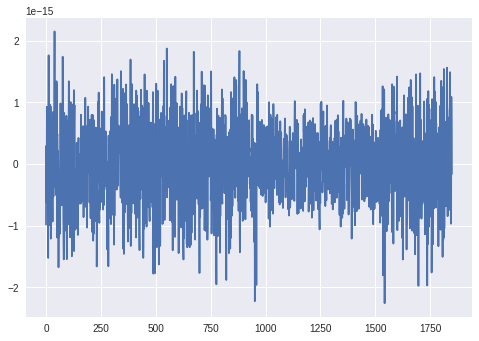

In [ ]:
new_df['X_Rot'].plot()

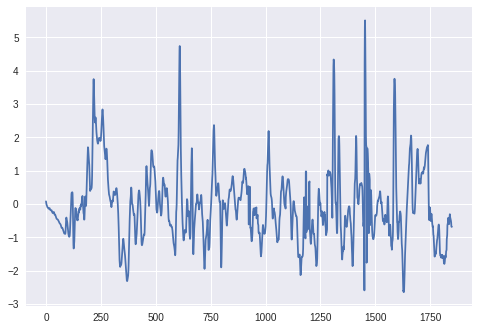

In [ ]:
new_df['X_Rot_move'].plot()

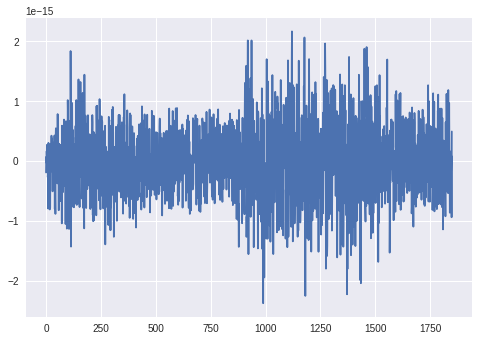

In [ ]:
new_df['Y_Rot'].plot()

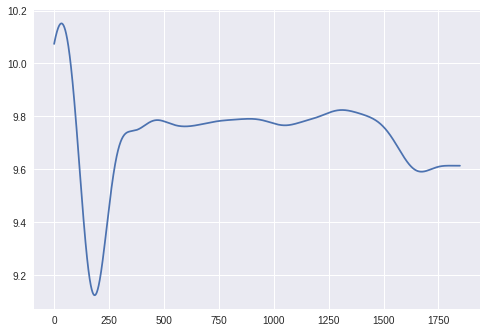

In [ ]:
new_df['Z_Rot'].plot()

In [ ]:
new_df['Z_Rot'].mean()

9.726793548275513

In [ ]:
new_df.shape

(1849, 6)

-------------------------------------------------

how does a 1 unit change in Yaw yield:

In [ ]:

delta_list = np.arange(0,1,0.01)

In [ ]:


for delta in np.arange(0,1,0.01):

  # Uses Acc
  pitch_1 = Theta( x1_median_20hz_gravity[0] , y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0] )
  roll_1 = Phi( y1_median_20hz_gravity[0] ,  z1_median_20hz_gravity[0]  )

  x_mag = raw_mag_1_resampled['X Axis'][0]
  y_mag = raw_mag_1_resampled['Y Axis'][0]
  z_mag = raw_mag_1_resampled['Z Axis'][0]

  # uses Mag 
  yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)

  #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
  R1_1 = Rz(yaw_1) * Ry(pitch_1+delta) * Rx(roll_1 )


  # put into array for multiplication 
  array_test = [ [x1_median_20hz_gravity[0]] , [y1_median_20hz_gravity[0]] ,  [z1_median_20hz_gravity[0]] ]

  # put movement acc into array for multiplication 
  array_test_move = [ [x1_median_20hz_movement[0]] , [y1_median_20hz_movement[0]] ,  [z1_median_20hz_movement[0]] ]

  # rotated values 
  rot_x , rot_y , rot_z = R1 * array_test

  # rotated values 
  rot_x_1 , rot_y_1 , rot_z_1 = R1 * array_test


  print("\n\nNormal: ", rot_z , "angle" , yaw_1) 
  print(f"Normal + {delta} : ", rot_z_1, "angle" , yaw_1+delta) 

  print("Abs Change : ", "{:.20f}".format(float(rot_z_1 - rot_z))  )

  print("\n\n------------------------------------------")





Normal:  [[10.073899]] angle 0.3535861336216912
Normal + 0.0 :  [[10.073899]] angle 0.3535861336216912
Abs Change :  0.00000000000000000000


------------------------------------------


Normal:  [[10.073899]] angle 0.3535861336216912
Normal + 0.01 :  [[10.073899]] angle 0.36358613362169123
Abs Change :  0.00000000000000000000


------------------------------------------


Normal:  [[10.073899]] angle 0.3535861336216912
Normal + 0.02 :  [[10.073899]] angle 0.37358613362169124
Abs Change :  0.00000000000000000000


------------------------------------------


Normal:  [[10.073899]] angle 0.3535861336216912
Normal + 0.03 :  [[10.073899]] angle 0.38358613362169125
Abs Change :  0.00000000000000000000


------------------------------------------


Normal:  [[10.073899]] angle 0.3535861336216912
Normal + 0.04 :  [[10.073899]] angle 0.3935861336216912
Abs Change :  0.00000000000000000000


------------------------------------------


Normal:  [[10.073899]] angle 0.3535861336216912
Normal +

------------------------------

Far too computation

In [ ]:
# # Now repeat for each stage 

# x_rotted = [] 
# y_rotted = [] 
# z_rotted = [] 


# angle_roll = []
# angle_pitch = []
# angle_yaw = []



# for i in range(len(x1_median_20hz_gravity)):


#   # Uses Acc
#   pitch_1 = Theta( x1_median_20hz_gravity[i] , y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i] )
#   roll_1 = Phi( y1_median_20hz_gravity[i] ,  z1_median_20hz_gravity[i]  )

#   x_mag = raw_mag_1_resampled['X Axis'][i]
#   y_mag = raw_mag_1_resampled['Y Axis'][i]
#   z_mag = raw_mag_1_resampled['Z Axis'][i]

#   # uses Mag 
#   yaw_1 = psi( x_mag  , y_mag , z_mag  , roll = roll_1 , pitch = pitch_1)


#   #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#   R1 = Rz(yaw_1) * Ry(pitch_1) * Rx(roll_1)


#   # put into array for multiplication 
#   array_test = [ [x1_median_20hz_gravity[i]] , [y1_median_20hz_gravity[i]] ,  [z1_median_20hz_gravity[i]] ]

#   # put movement acc into array for multiplication 
#   array_test_move = [ [x1_median_20hz_movement[i]] , [y1_median_20hz_movement[i]] ,  [z1_median_20hz_movement[i]] ]

#   # rotated values 
#   rot_x , rot_y , rot_z = R1 * array_test


#   if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#     # append 

#     #print(f"Hit on original")

#     x_rotted.append(rot_x)
#     y_rotted.append(rot_y)
#     z_rotted.append(rot_z)

#     angle_roll.append(roll_1)
#     angle_pitch.append(pitch_1)
#     angle_yaw.append(yaw_1)


#   else: 

#     #print("Enter Else")

#     ############################# Change Yaw ####################

#     for delta in range(-5,5):

#       yaw_1_delta = yaw_1 + delta 
#       roll_1_delta = roll_1 
#       pitch_1_delta = pitch_1 


#       #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#       R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#       # rotated values 
#       rot_x , rot_y , rot_z = R1 * array_test


#       if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#       # append 
#         x_rotted.append(rot_x)
#         y_rotted.append(rot_y)
#         z_rotted.append(rot_z)

#         angle_roll.append(roll_1_delta)
#         angle_pitch.append( pitch_1_delta)
#         angle_yaw.append(yaw_1_delta)

#         print(f"Hit on: {delta}")



#       ############################# Change Roll ####################

#       for delta in range(-5,5):

#         yaw_1_delta = yaw_1
#         roll_1_delta = roll_1  + delta 
#         pitch_1_delta = pitch_1 


#         #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#         R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#         # rotated values 
#         rot_x , rot_y , rot_z = R1 * array_test


#         if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#         # append 
#           x_rotted.append(rot_x)
#           y_rotted.append(rot_y)
#           z_rotted.append(rot_z)

#           angle_roll.append(roll_1_delta)
#           angle_pitch.append( pitch_1_delta)
#           angle_yaw.append(yaw_1_delta)

#           print(f"Hit on: {delta}")


#         ############################# Change Pitch ####################

#         for delta in range(-5,5):

#           yaw_1_delta = yaw_1
#           roll_1_delta = roll_1   
#           pitch_1_delta = pitch_1 + delta


#           #Create a rotation matrix for each sensor to normalize the orientation of the phone in each test
#           R1 = Rz(yaw_1_delta) * Ry( pitch_1_delta) * Rx(roll_1_delta)

#           # rotated values 
#           rot_x , rot_y , rot_z = R1 * array_test


#           if rot_z >= 9.8 and rot_z <= 9.82 and rot_x <= 0.001 and rot_y <= 0.001:
#           # append 
#             x_rotted.append(rot_x)
#             y_rotted.append(rot_y)
#             z_rotted.append(rot_z)

#             angle_roll.append(roll_1_delta)
#             angle_pitch.append( pitch_1_delta)
#             angle_yaw.append(yaw_1_delta)

#             print(f"Hit on: {delta}")


In [ ]:
len(x1_median_20hz_gravity) 



1849

In [ ]:
# len(angle_roll)

In [ ]:
# arr_x_rotted = np.array(x_rotted)
# arr_y_rotted = np.array(y_rotted)
# arr_z_rotted = np.array(z_rotted)

In [ ]:
# arr_x_rotted_squeez = np.squeeze(arr_x_rotted)
# arr_y_rotted_squeez = np.squeeze(arr_y_rotted)
# arr_z_rotted_squeez = np.squeeze(arr_z_rotted)

In [ ]:
# new_df = pd.DataFrame()

# new_df['X_Rot'] = arr_x_rotted_squeez 
# new_df['Y_Rot'] = arr_y_rotted_squeez 
# new_df['Z_Rot'] = arr_z_rotted_squeez 


In [ ]:
# plt.plot(new_df.index, new_df['Z_Rot'])
# plt.ylim(0,10)
# plt.show()



In [ ]:
# new_df['X_Rot'].plot()


In [ ]:
# new_df['Y_Rot'].plot()

-----------------------

In [ ]:
# import modules
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')

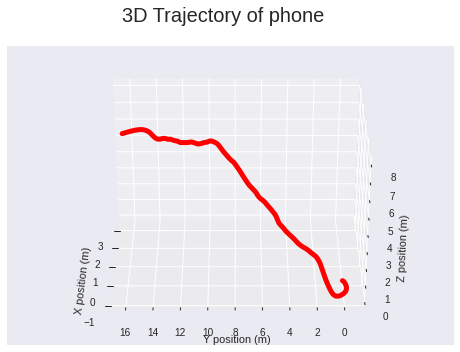

In [ ]:
dt = 0.01

# Double integrate accelerations to find positions
x =cumtrapz(cumtrapz(new_df['X_Rot_move'],dx=dt),dx=dt)
y =cumtrapz(cumtrapz(new_df['Y_Rot_move'],dx=dt),dx=dt)
z =cumtrapz(cumtrapz(new_df['Z_Rot_move'],dx=dt),dx=dt)# Plot 3D Trajectory


fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')


# Set rotation angle to 30 degrees
ax.view_init(azim=180)

plt.show()




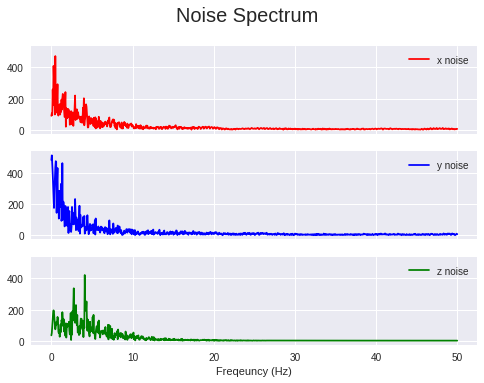

In [ ]:
# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(new_df['X_Rot_move'].size,d=dt)

# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(new_df['X_Rot_move']) 
fft_y = np.fft.rfft(new_df['Y_Rot_move']) 
fft_z = np.fft.rfft(new_df['Z_Rot_move'])

# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Freqeuncy (Hz)')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:191: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


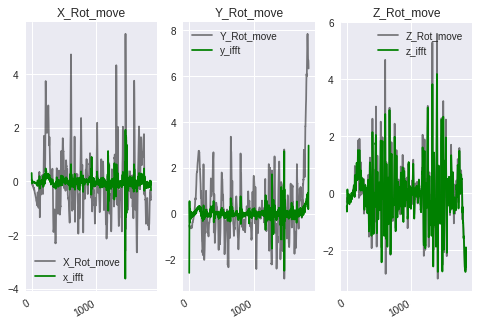

In [ ]:
# Attenuate noise in X,Y below 10Hz by 10 dB
# Attenuate noise <10Hz and >5Hz in Z axis by 10 dB
atten_x_fft = np.where(freq < 10,fft_x * 0.1, fft_x) 
atten_y_fft = np.where(freq < 10,fft_y * 0.1, fft_y) 
atten_z_fft = np.where((freq > 5) & (freq < 10),fft_z * 0.1, fft_z) 


# Compute inverse of discrete Fourier Transform 
new_df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
new_df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
new_df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])


# Plot new acceleration signals
cols_raw = ['X_Rot_move','Y_Rot_move','Z_Rot_move']
cols_new = ['x_ifft','y_ifft','z_ifft']

rawplot = new_df.plot( y=cols_raw, subplots=True, sharex=True, style='k', title=cols_raw, alpha=0.5 , layout = (1,3))

new_df.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot,sharex=True,style='g')
plt.show()

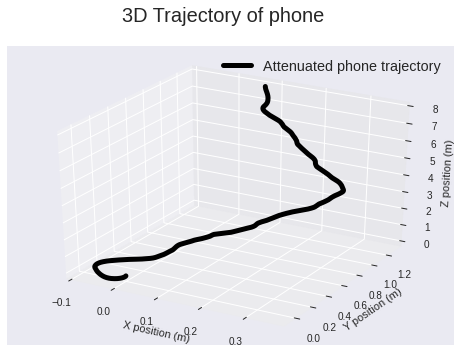

In [ ]:
dt = 0.01



# Double integrate accelerations to calculate coordinate positions
x = cumtrapz(cumtrapz(new_df['x_ifft'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(new_df['y_ifft'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(new_df['z_ifft'],dx=dt),dx=dt)



fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)


# Plot attenuated 3D Trajectory
ax = plt.axes(projection='3d')

ax.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')

ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')

ax.legend(fontsize='x-large')
plt.show()

-------------------------------------

In [ ]:
new_df.tail()

,X_Rot,Y_Rot,Z_Rot,X_Rot_move,Y_Rot_move,Z_Rot_move,x_ifft,y_ifft,z_ifft
1844,-9.691762e-16,6.550560e-17,9.613869,-0.502561,6.699977,-2.366399,0.020823,0.214877,-1.960147
1845,-6.609936e-16,-1.588483e-16,9.613868,-0.553453,6.681685,-2.363886,-0.007285,0.505228,-1.909197
1846,1.089163e-15,8.724100e-17,9.613867,-0.664832,6.612733,-2.408303,-0.140013,1.081951,-2.001441
1847,6.795603e-16,-9.382227e-16,9.613867,-0.685591,6.493835,-2.521818,-0.227556,1.929686,-2.251108
1848,-1.612622e-16,4.950129e-16,9.613867,-0.682379,6.338915,-2.689870,-0.326450,2.974597,-2.614106


----------------------------------------

.

In [ ]:
np.sign(0)

0

In [ ]:
change_of_sign = []

a = [ 0 , 2 , -2 ,-3 , -4 , 5 ,6 ]


# iterate through the values of the segment
sign_change = 0

for i in a:

  # determine sign manually just so that there is  no confusions around 0 if it occurs

  # This is the starting sign value of the segment, if positive start sign = 1 
  if a[0] >= 0:
    start_sign = 1
  
  # else its negative = 0 
  else:
    start_sign = 0

 # This is the current sign value in the segment, if positive start sign = 1 
  if i >= 0:
    current_sign = 1

  else:
    current_sign = 0




  # if start sign and current sign differ, must be a sign change , so set sign change = 1 to represent a change in sign 
  if start_sign != current_sign:

    # means there was a change
    sign_change = 1


change_of_sign.append(sign_change )



In [ ]:
print(change_of_sign)

[1]


.

.

.

# Look into markers

In [ ]:
marker_1 = pd.read_csv("08-04-2015 13.06.09.853 - TrialFPSV3502 - Markers.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
marker_1.head()

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4
0,1428494769868,-115915.0,0.0,Original Sync,NaN
1,1428494769871,-115905.0,0.0,Sync from Start Service Ack,NaN
2,1428494788527,-115901.0,18656.0,Sync from Stop Service Ack,NaN
3,1428494770898,-115901.0,1027.0,Go,NaN
4,1428494773683,-115901.0,3812.0,Walk,NaN


In [ ]:
marker_1.isna().sum()

Local Time (ms)        0
Local-Remote time      1
Relative Time (ms)     1
Label                  1
Unnamed: 4            10
dtype: int64

In [ ]:
marker_1.tail()

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4
5,1428494779634,-115901.0,9763.0,Turn,NaN
6,1428494781680,-115901.0,11809.0,Walk,NaN
7,1428494785974,-115901.0,16103.0,Turn,NaN
8,1428494787207,-115901.0,17336.0,sit,NaN
9,<== CSV Log file finishes at: 08-04-2015 13.06...,NaN,NaN,NaN,NaN


In [ ]:
print(len(marker_1))

10


In [ ]:
marker_1.shape

(10, 5)

In [ ]:
marker_1 = marker_1.drop(len(marker_1)-1)

In [ ]:
marker_1.dtypes

Local Time (ms)        object
Local-Remote time     float64
Relative Time (ms)    float64
Label                  object
Unnamed: 4            float64
dtype: object

In [ ]:
marker_1 = marker_1.astype({'Local Time (ms)': float})

In [ ]:
marker_1.dtypes

Local Time (ms)       float64
Local-Remote time     float64
Relative Time (ms)    float64
Label                  object
Unnamed: 4            float64
dtype: object

# Reorder in ascending in local time 

In [ ]:
marker_1.sort_values(by=['Local Time (ms)'], inplace=True, ascending=True)

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN
3,1.428495e+12,-115901.0,1027.0,Go,NaN
4,1.428495e+12,-115901.0,3812.0,Walk,NaN
5,1.428495e+12,-115901.0,9763.0,Turn,NaN
6,1.428495e+12,-115901.0,11809.0,Walk,NaN
7,1.428495e+12,-115901.0,16103.0,Turn,NaN
8,1.428495e+12,-115901.0,17336.0,sit,NaN
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN


# Use Relative time instead , didnt seem to work? Or is timestamp off 

In [ ]:
marker_1.sort_values(by=['Relative Time (ms)'], inplace=True, ascending=True)

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN
3,1.428495e+12,-115901.0,1027.0,Go,NaN
4,1.428495e+12,-115901.0,3812.0,Walk,NaN
5,1.428495e+12,-115901.0,9763.0,Turn,NaN
6,1.428495e+12,-115901.0,11809.0,Walk,NaN
7,1.428495e+12,-115901.0,16103.0,Turn,NaN
8,1.428495e+12,-115901.0,17336.0,sit,NaN
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN


Make a datetime type  

In [ ]:
marker_1['Test']  =  pd.to_datetime(marker_1['Relative Time (ms)'], unit='ms')

-----------------------------------------------

Not sure if this is used, think its roughwork 

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027
4,1.428495e+12,-115901.0,3812.0,Walk,NaN,1970-01-01 00:00:03.812
5,1.428495e+12,-115901.0,9763.0,Turn,NaN,1970-01-01 00:00:09.763
6,1.428495e+12,-115901.0,11809.0,Walk,NaN,1970-01-01 00:00:11.809
7,1.428495e+12,-115901.0,16103.0,Turn,NaN,1970-01-01 00:00:16.103
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656


In [ ]:
marker_1['Test_2'] = marker_1['Local Time (ms)'] + marker_1['Local-Remote time']

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12
4,1.428495e+12,-115901.0,3812.0,Walk,NaN,1970-01-01 00:00:03.812,1.428495e+12
5,1.428495e+12,-115901.0,9763.0,Turn,NaN,1970-01-01 00:00:09.763,1.428495e+12
6,1.428495e+12,-115901.0,11809.0,Walk,NaN,1970-01-01 00:00:11.809,1.428495e+12
7,1.428495e+12,-115901.0,16103.0,Turn,NaN,1970-01-01 00:00:16.103,1.428495e+12
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12


In [ ]:
marker_1['Test_3']  =  pd.to_datetime(marker_1['Test'], unit='ms')

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2,Test_3
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12,1970-01-01 00:00:01.027
4,1.428495e+12,-115901.0,3812.0,Walk,NaN,1970-01-01 00:00:03.812,1.428495e+12,1970-01-01 00:00:03.812
5,1.428495e+12,-115901.0,9763.0,Turn,NaN,1970-01-01 00:00:09.763,1.428495e+12,1970-01-01 00:00:09.763
6,1.428495e+12,-115901.0,11809.0,Walk,NaN,1970-01-01 00:00:11.809,1.428495e+12,1970-01-01 00:00:11.809
7,1.428495e+12,-115901.0,16103.0,Turn,NaN,1970-01-01 00:00:16.103,1.428495e+12,1970-01-01 00:00:16.103
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12,1970-01-01 00:00:17.336
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12,1970-01-01 00:00:18.656


In [ ]:
marker_1['Test_3'] == marker_1['Test']

0    True
1    True
3    True
4    True
5    True
6    True
7    True
8    True
2    True
dtype: bool

------------------------------------------------------------------

# Rename elements 

In [ ]:
# rename to walk 1 
marker_1.at[4, 'Label'] = 'Walk 1'

#rename to turn 1 
marker_1.at[5, 'Label'] = 'Turn 1'

# rename to walk 2
marker_1.at[6, 'Label'] = 'Walk 2'

#rename to turn 2
marker_1.at[7, 'Label'] = 'Turn 2'



In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2,Test_3
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12,1970-01-01 00:00:01.027
4,1.428495e+12,-115901.0,3812.0,Walk 1,NaN,1970-01-01 00:00:03.812,1.428495e+12,1970-01-01 00:00:03.812
5,1.428495e+12,-115901.0,9763.0,Turn 1,NaN,1970-01-01 00:00:09.763,1.428495e+12,1970-01-01 00:00:09.763
6,1.428495e+12,-115901.0,11809.0,Walk 2,NaN,1970-01-01 00:00:11.809,1.428495e+12,1970-01-01 00:00:11.809
7,1.428495e+12,-115901.0,16103.0,Turn 2,NaN,1970-01-01 00:00:16.103,1.428495e+12,1970-01-01 00:00:16.103
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12,1970-01-01 00:00:17.336
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12,1970-01-01 00:00:18.656


-------------------------------------------------------

In [ ]:
raw_acc_1_1 = pd.read_csv("08-04-2015 04.08.05.518 - Right Coat Pocket - TrialFPSV3502 - Raw Acceleration.csv" , 
                        skiprows=0 ,  header=1 )

In [ ]:
raw_acc_1_1 = raw_acc_1_1.drop(1848)

In [ ]:
# convert Relative time to ns 

# ms  10^-3    ns 10^-9      ms -> ns  multiply by 10^6 

In [ ]:
marker_1['RTNS'] = marker_1['Relative Time (ms)'] * (10**6)

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2,Test_3,RTNS
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12,1970-01-01 00:00:01.027,1.027000e+09
4,1.428495e+12,-115901.0,3812.0,Walk 1,NaN,1970-01-01 00:00:03.812,1.428495e+12,1970-01-01 00:00:03.812,3.812000e+09
5,1.428495e+12,-115901.0,9763.0,Turn 1,NaN,1970-01-01 00:00:09.763,1.428495e+12,1970-01-01 00:00:09.763,9.763000e+09
6,1.428495e+12,-115901.0,11809.0,Walk 2,NaN,1970-01-01 00:00:11.809,1.428495e+12,1970-01-01 00:00:11.809,1.180900e+10
7,1.428495e+12,-115901.0,16103.0,Turn 2,NaN,1970-01-01 00:00:16.103,1.428495e+12,1970-01-01 00:00:16.103,1.610300e+10
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12,1970-01-01 00:00:17.336,1.733600e+10
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12,1970-01-01 00:00:18.656,1.865600e+10


In [ ]:
raw_acc_1_1['Event Time (ns)'][0]

277451507534.0

In [ ]:
# now add onto it the event time from raw acceleration 

marker_1['New'] = marker_1['RTNS'] + raw_acc_1_1['Event Time (ns)'][0]

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2,Test_3,RTNS,New
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00,2.774515e+11
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00,2.774515e+11
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12,1970-01-01 00:00:01.027,1.027000e+09,2.784785e+11
4,1.428495e+12,-115901.0,3812.0,Walk 1,NaN,1970-01-01 00:00:03.812,1.428495e+12,1970-01-01 00:00:03.812,3.812000e+09,2.812635e+11
5,1.428495e+12,-115901.0,9763.0,Turn 1,NaN,1970-01-01 00:00:09.763,1.428495e+12,1970-01-01 00:00:09.763,9.763000e+09,2.872145e+11
6,1.428495e+12,-115901.0,11809.0,Walk 2,NaN,1970-01-01 00:00:11.809,1.428495e+12,1970-01-01 00:00:11.809,1.180900e+10,2.892605e+11
7,1.428495e+12,-115901.0,16103.0,Turn 2,NaN,1970-01-01 00:00:16.103,1.428495e+12,1970-01-01 00:00:16.103,1.610300e+10,2.935545e+11
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12,1970-01-01 00:00:17.336,1.733600e+10,2.947875e+11
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12,1970-01-01 00:00:18.656,1.865600e+10,2.961075e+11


In [ ]:
marker_1['Last Time']  =  pd.to_datetime(marker_1['New'], unit='ns')

In [ ]:
marker_1

,Local Time (ms),Local-Remote time,Relative Time (ms),Label,Unnamed: 4,Test,Test_2,Test_3,RTNS,New,Last Time
0,1.428495e+12,-115915.0,0.0,Original Sync,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00,2.774515e+11,1970-01-01 00:04:37.451507534
1,1.428495e+12,-115905.0,0.0,Sync from Start Service Ack,NaN,1970-01-01 00:00:00.000,1.428495e+12,1970-01-01 00:00:00.000,0.000000e+00,2.774515e+11,1970-01-01 00:04:37.451507534
3,1.428495e+12,-115901.0,1027.0,Go,NaN,1970-01-01 00:00:01.027,1.428495e+12,1970-01-01 00:00:01.027,1.027000e+09,2.784785e+11,1970-01-01 00:04:38.478507534
4,1.428495e+12,-115901.0,3812.0,Walk 1,NaN,1970-01-01 00:00:03.812,1.428495e+12,1970-01-01 00:00:03.812,3.812000e+09,2.812635e+11,1970-01-01 00:04:41.263507534
5,1.428495e+12,-115901.0,9763.0,Turn 1,NaN,1970-01-01 00:00:09.763,1.428495e+12,1970-01-01 00:00:09.763,9.763000e+09,2.872145e+11,1970-01-01 00:04:47.214507534
6,1.428495e+12,-115901.0,11809.0,Walk 2,NaN,1970-01-01 00:00:11.809,1.428495e+12,1970-01-01 00:00:11.809,1.180900e+10,2.892605e+11,1970-01-01 00:04:49.260507534
7,1.428495e+12,-115901.0,16103.0,Turn 2,NaN,1970-01-01 00:00:16.103,1.428495e+12,1970-01-01 00:00:16.103,1.610300e+10,2.935545e+11,1970-01-01 00:04:53.554507534
8,1.428495e+12,-115901.0,17336.0,sit,NaN,1970-01-01 00:00:17.336,1.428495e+12,1970-01-01 00:00:17.336,1.733600e+10,2.947875e+11,1970-01-01 00:04:54.787507534
2,1.428495e+12,-115901.0,18656.0,Sync from Stop Service Ack,NaN,1970-01-01 00:00:18.656,1.428495e+12,1970-01-01 00:00:18.656,1.865600e+10,2.961075e+11,1970-01-01 00:04:56.107507534


----------------------------------------------------------

In [ ]:
of_interest = marker_1[['Last Time', 'Label']]

In [ ]:
of_interest

,Last Time,Label
0,1970-01-01 00:04:37.451507534,Original Sync
1,1970-01-01 00:04:37.451507534,Sync from Start Service Ack
3,1970-01-01 00:04:38.478507534,Go
4,1970-01-01 00:04:41.263507534,Walk 1
5,1970-01-01 00:04:47.214507534,Turn 1
6,1970-01-01 00:04:49.260507534,Walk 2
7,1970-01-01 00:04:53.554507534,Turn 2
8,1970-01-01 00:04:54.787507534,sit
2,1970-01-01 00:04:56.107507534,Sync from Stop Service Ack


In [ ]:
# need to drop the first row as its duplicate in the terms of index

of_interest = of_interest.drop(0)

In [ ]:
of_interest.set_index('Last Time' ,  inplace=True)

In [ ]:
of_interest

,Label
Last Time,
1970-01-01 00:04:37.451507534,Sync from Start Service Ack
1970-01-01 00:04:38.478507534,Go
1970-01-01 00:04:41.263507534,Walk 1
1970-01-01 00:04:47.214507534,Turn 1
1970-01-01 00:04:49.260507534,Walk 2
1970-01-01 00:04:53.554507534,Turn 2
1970-01-01 00:04:54.787507534,sit
1970-01-01 00:04:56.107507534,Sync from Stop Service Ack


In [ ]:
labels = of_interest.Label.values

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


In [ ]:
of_interest['Cat_Label'] = le.fit_transform(of_interest['Label'])

In [ ]:
of_interest

,Label,Cat_Label
Last Time,,
1970-01-01 00:04:37.451507534,Sync from Start Service Ack,1
1970-01-01 00:04:38.478507534,Go,0
1970-01-01 00:04:41.263507534,Walk 1,5
1970-01-01 00:04:47.214507534,Turn 1,3
1970-01-01 00:04:49.260507534,Walk 2,6
1970-01-01 00:04:53.554507534,Turn 2,4
1970-01-01 00:04:54.787507534,sit,7
1970-01-01 00:04:56.107507534,Sync from Stop Service Ack,2


In [ ]:
#convert labels to vals  
#of_interest["Cat_Label"] =  of_interest["Label"].astype('category')

In [ ]:
#of_interest["Cat_Label"] = of_interest["Cat_Label"].cat.codes

In [ ]:
#new_interest = of_interest.drop(['Cat'] , axis = 1)

In [ ]:
of_interest = of_interest.resample('10000000NS').bfill()

-------------------------------------

In [ ]:
last_df = pd.concat([raw_acc_1_resampled, of_interest ] , axis = 1)

In [ ]:
last_df

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label
Time,,,,,,
1970-01-01 00:04:37.450,2.774515e+11,-6.100115,-2.876119,7.323521,Sync from Start Service Ack,1
1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683,Go,0
1970-01-01 00:04:37.470,2.774715e+11,-5.949977,-2.938539,7.375313,Go,0
1970-01-01 00:04:37.480,2.774815e+11,-6.266419,-2.756069,7.297475,Go,0
1970-01-01 00:04:37.490,2.774915e+11,-6.055358,-2.788551,7.098239,Go,0
...,...,...,...,...,...,...
1970-01-01 00:04:56.060,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:56.070,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:56.080,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2


In [ ]:
last_df.tail(20)

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label
Time,,,,,,
1970-01-01 00:04:55.910,2.959109e+11,-5.924829,-3.545078,6.728957,Sync from Stop Service Ack,2
1970-01-01 00:04:55.920,2.959209e+11,-6.155649,-3.358266,6.583909,Sync from Stop Service Ack,2
1970-01-01 00:04:55.930,2.959309e+11,-6.349047,-3.184029,7.048093,Sync from Stop Service Ack,2
1970-01-01 00:04:55.940,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:55.950,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:55.960,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:55.970,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:55.980,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2
1970-01-01 00:04:55.990,NaN,NaN,NaN,NaN,Sync from Stop Service Ack,2


In [ ]:
last_df.isna().sum()

Event Time (ns)    17
X Axis             17
Y Axis             17
Z Axis             17
Label               0
Cat_Label           0
dtype: int64

In [ ]:
last_df.shape

(1866, 6)

In [ ]:
# filter out nan at the end 

last_df = last_df.dropna()

In [ ]:
last_df.tail(20)

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label
Time,,,,,,
1970-01-01 00:04:55.740,2.957411e+11,-6.186336,-2.800077,8.223748,Sync from Stop Service Ack,2
1970-01-01 00:04:55.750,2.957511e+11,-6.217171,-2.880909,8.035440,Sync from Stop Service Ack,2
1970-01-01 00:04:55.760,2.957610e+11,-6.042335,-2.557731,7.990085,Sync from Stop Service Ack,2
1970-01-01 00:04:55.770,2.957710e+11,-6.193371,-2.379452,8.173004,Sync from Stop Service Ack,2
1970-01-01 00:04:55.780,2.957810e+11,-6.146518,-2.698139,7.977062,Sync from Stop Service Ack,2
1970-01-01 00:04:55.790,2.957910e+11,-6.174510,-2.839595,7.923024,Sync from Stop Service Ack,2
1970-01-01 00:04:55.800,2.958010e+11,-5.999374,-2.947072,7.516170,Sync from Stop Service Ack,2
1970-01-01 00:04:55.810,2.958110e+11,-6.111791,-2.651137,7.667355,Sync from Stop Service Ack,2
1970-01-01 00:04:55.820,2.958213e+11,-6.261030,-2.985841,7.360344,Sync from Stop Service Ack,2


--------------------------------------------

In [ ]:
last_df.shape

(1849, 6)

In [ ]:
last_df.head(10)

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label
Time,,,,,,
1970-01-01 00:04:37.450,2.774515e+11,-6.100115,-2.876119,7.323521,Sync from Start Service Ack,1
1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683,Go,0
1970-01-01 00:04:37.470,2.774715e+11,-5.949977,-2.938539,7.375313,Go,0
1970-01-01 00:04:37.480,2.774815e+11,-6.266419,-2.756069,7.297475,Go,0
1970-01-01 00:04:37.490,2.774915e+11,-6.055358,-2.788551,7.098239,Go,0
1970-01-01 00:04:37.500,2.775015e+11,-6.041287,-2.699786,7.265292,Go,0
1970-01-01 00:04:37.510,2.775115e+11,-6.189030,-2.863246,7.369774,Go,0
1970-01-01 00:04:37.520,2.775215e+11,-6.363417,-2.733316,7.303762,Go,0
1970-01-01 00:04:37.530,2.775315e+11,-6.051166,-2.720892,7.257657,Go,0


In [ ]:
last_df['Label'].unique()

array(['Sync from Start Service Ack', 'Go', 'Walk 1', 'Turn 1', 'Walk 2',
       'Turn 2', 'sit', 'Sync from Stop Service Ack'], dtype=object)

In [ ]:
last_df.shape

(1849, 6)

---------------------------------------

In [ ]:
# # since drop out stop sync service need to remove some of the data fro median filter

# len(x1_median_20hz[:-116])

# len(y1_median_20hz[:-116])

# len(z1_median_20hz[:-116])

In [ ]:
last_df['Accel X'] = x1_median_20hz_movement
last_df['Accel Y'] = y1_median_20hz_movement
last_df['Accel Z'] = z1_median_20hz_movement

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
last_df.tail()

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label,Accel X,Accel Y,Accel Z
Time,,,,,,,,,
1970-01-01 00:04:55.890,2.958910e+11,-6.060597,-3.556754,6.900650,Sync from Stop Service Ack,2,-0.494577,4.305793,5.653109
1970-01-01 00:04:55.900,2.959009e+11,-6.232889,-3.307073,7.030430,Sync from Stop Service Ack,2,-0.531780,4.323634,5.618058
1970-01-01 00:04:55.910,2.959109e+11,-5.924829,-3.545078,6.728957,Sync from Stop Service Ack,2,-0.529005,4.362895,5.536738
1970-01-01 00:04:55.920,2.959209e+11,-6.155649,-3.358266,6.583909,Sync from Stop Service Ack,2,-0.453712,4.426603,5.403594
1970-01-01 00:04:55.930,2.959309e+11,-6.349047,-3.184029,7.048093,Sync from Stop Service Ack,2,-0.320145,4.510337,5.238059


-------------------------

------------------------------

FFT Testing 

https://realpython.com/python-scipy-fft/

<br>

<br>


In [ ]:
from scipy.fft import fft, fftfreq , rfft , rfftfreq

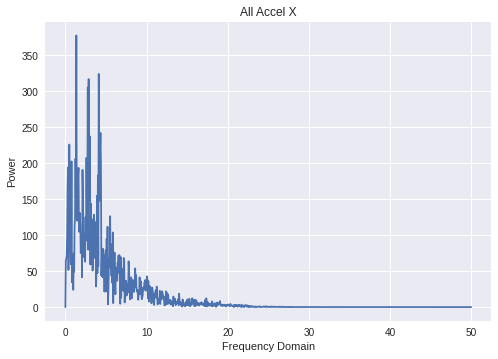

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

# Sampling rate is 100Hz 
SAMPLE_RATE = 100

# Detrending data (advice from stack overflow to overcome 0 Hz main frequency)
all = (last_df['Accel X'].values - last_df['Accel X'].values.mean())

# Applying FFT
yf = rfft(all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


# Plots
plt.xlabel("Frequency Domain")
plt.ylabel("Power")
plt.title("All Accel X")

#plt.xlim(-1,20)

plt.plot(xf, np.abs(yf))
plt.show()

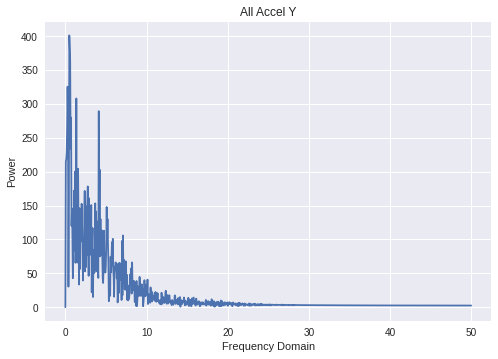

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

SAMPLE_RATE = 100

input_all = (last_df['Accel Y'].values) - (last_df['Accel Y'].values.mean())

yf = rfft(input_all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.title("All Accel Y")


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(-1,20)

plt.plot(xf, np.abs(yf))
plt.show()

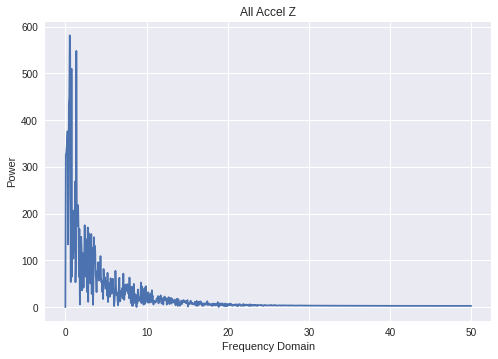

In [ ]:
# Number of samples in signal
N = last_df.shape[0]

SAMPLE_RATE = 100

input_all = (last_df['Accel Z'].values) - (last_df['Accel Z'].values.mean())

yf = rfft(input_all)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("All Accel Z")

#plt.xlim(0,3)

plt.plot(xf, np.abs(yf))
plt.show()

------------------------------------------------

# Go

**X**

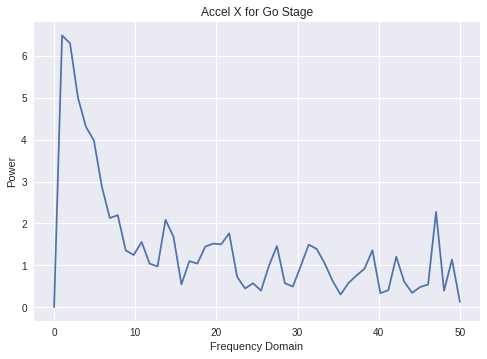

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

# Sampling rate is 100Hz 
SAMPLE_RATE = 100


# Detrending data (advice from stack overflow to overcome 0 Hz main frequency)
go_x = (last_df[last_df['Label'] == 'Go']['X Axis'].values) - (last_df[last_df['Label'] == 'Go']['X Axis'].values.mean())

yf = rfft(go_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

# Plots
plt.xlabel("Frequency Domain")
plt.ylabel("Power")
plt.title("Accel X for Go Stage")

#plt.xlim(-5, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

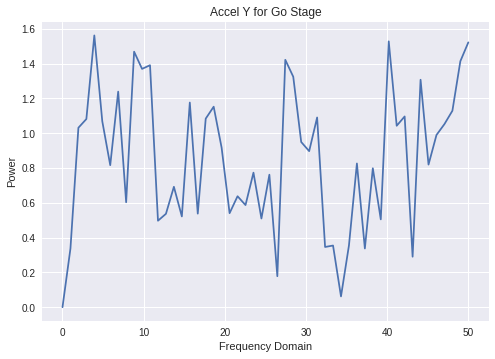

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

SAMPLE_RATE = 100

go_y = (last_df[last_df['Label'] == 'Go']['Y Axis'].values) - (last_df[last_df['Label'] == 'Go']['Y Axis'].values.mean())

yf = rfft(go_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.title("Accel Y for Go Stage")

plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

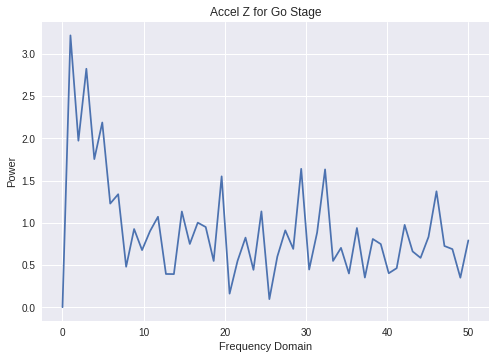

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Go'].shape[0]

SAMPLE_RATE = 100


# found stack overflow saying remove mean 
input = (last_df[last_df['Label'] == 'Go']['Z Axis'].values) - (last_df[last_df['Label'] == 'Go']['Z Axis'].values.mean())

yf = rfft(input)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.title("Accel Z for Go Stage")


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

#plt.xlim(0,5)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
xf[np.argmax(yf)]

0.9803921568627451

# Walk 1 

**X**

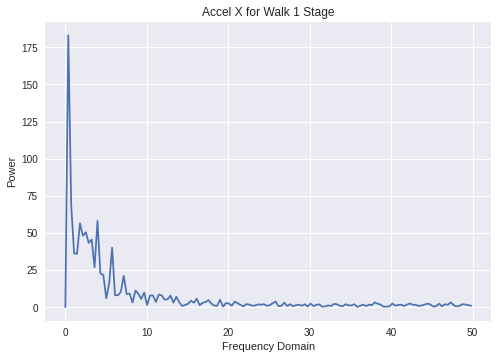

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_x = (last_df[last_df['Label'] == 'Walk 1']['X Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['X Axis'].values.mean())

yf = rfft(walk_1_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
max_freq = xf[np.argmax(np.abs(yf))]

print(max_freq)

0.35842293906810035


**Y**

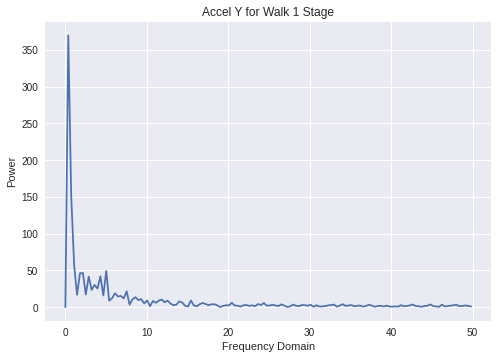

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_y = (last_df[last_df['Label'] == 'Walk 1']['Y Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['Y Axis'].values.mean())

yf = rfft(walk_1_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
max_freq = xf[np.argmax(np.abs(yf))]
print(max_freq)

0.35842293906810035


**Z**

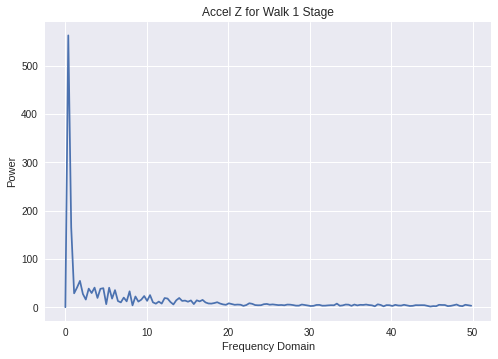

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 1'].shape[0]

SAMPLE_RATE = 100

walk_1_z = (last_df[last_df['Label'] == 'Walk 1']['Z Axis'].values) - (last_df[last_df['Label'] == 'Walk 1']['Z Axis'].values.mean())

yf = rfft(walk_1_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Walk 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Turn 1 

**X**

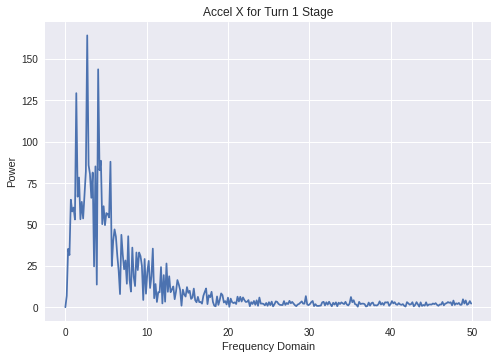

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_x = (last_df[last_df['Label'] == 'Turn 1']['X Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['X Axis'].values.mean())

yf = rfft(turn_1_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

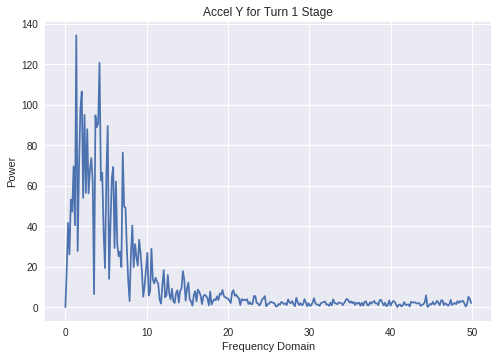

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_y = (last_df[last_df['Label'] == 'Turn 1']['Y Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['Y Axis'].values.mean())

yf = rfft(turn_1_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

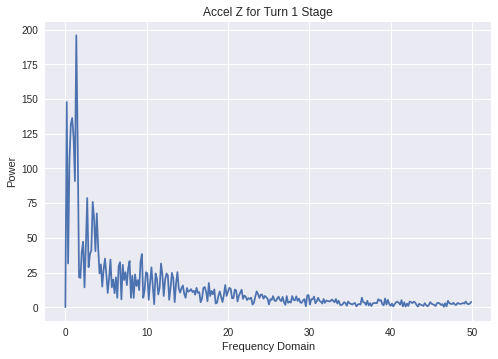

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 1'].shape[0]

SAMPLE_RATE = 100

turn_1_z = (last_df[last_df['Label'] == 'Turn 1']['Z Axis'].values) - (last_df[last_df['Label'] == 'Turn 1']['Z Axis'].values.mean())

yf = rfft(turn_1_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Turn 1 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Walk 2 

**X**

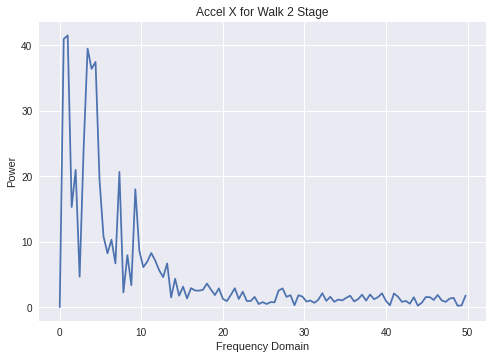

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_x = (last_df[last_df['Label'] == 'Walk 2']['X Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['X Axis'].values.mean())

yf = rfft(walk_2_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

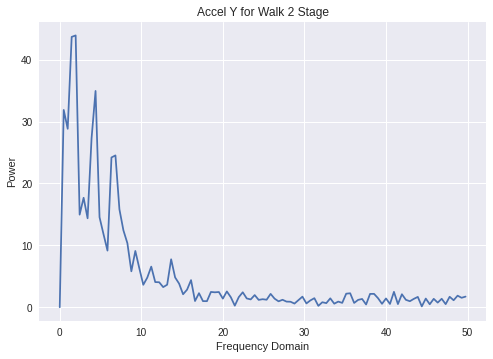

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_y = (last_df[last_df['Label'] == 'Walk 2']['Y Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['Y Axis'].values.mean())

yf = rfft(walk_2_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

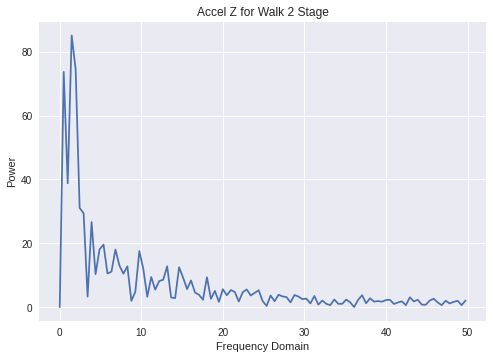

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Walk 2'].shape[0]

SAMPLE_RATE = 100

walk_2_z = (last_df[last_df['Label'] == 'Walk 2']['Z Axis'].values) - (last_df[last_df['Label'] == 'Walk 2']['Z Axis'].values.mean())

yf = rfft(walk_2_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Walk 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Turn 2 

**X**

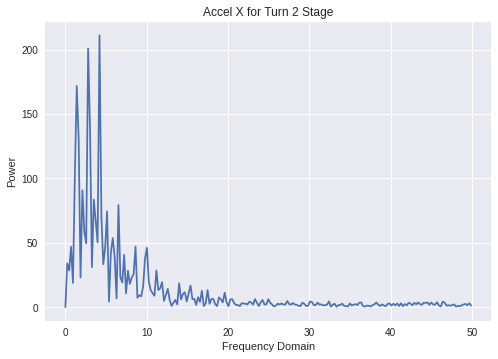

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_x = (last_df[last_df['Label'] == 'Turn 2']['X Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['X Axis'].values.mean())

yf = rfft(turn_2_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

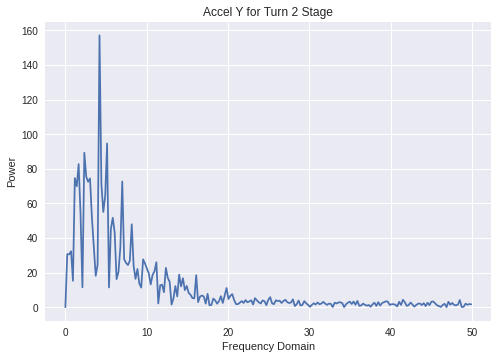

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_y = (last_df[last_df['Label'] == 'Turn 2']['Y Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['Y Axis'].values.mean())

yf = rfft(turn_2_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

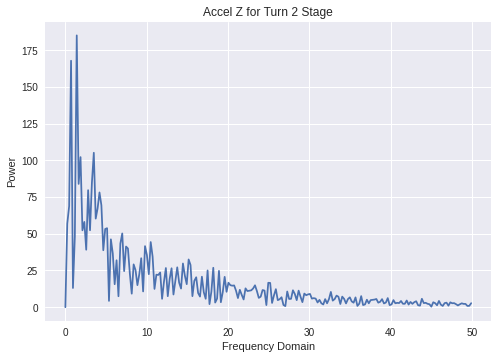

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'Turn 2'].shape[0]

SAMPLE_RATE = 100

turn_2_z = (last_df[last_df['Label'] == 'Turn 2']['Z Axis'].values) - (last_df[last_df['Label'] == 'Turn 2']['Z Axis'].values.mean())

yf = rfft(turn_2_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Turn 2 Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

# Sit

**X**

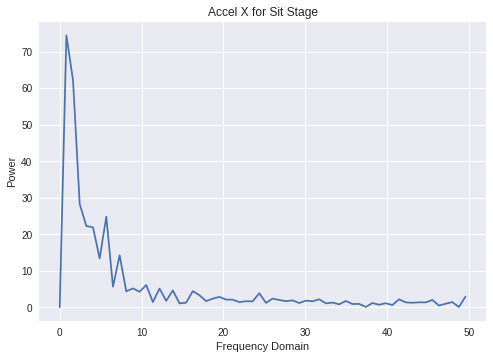

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]


SAMPLE_RATE = 100

sit_x = (last_df[last_df['Label'] == 'sit']['X Axis'].values) - (last_df[last_df['Label'] == 'sit']['X Axis'].values.mean())

yf = rfft(sit_x)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel X for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Y**

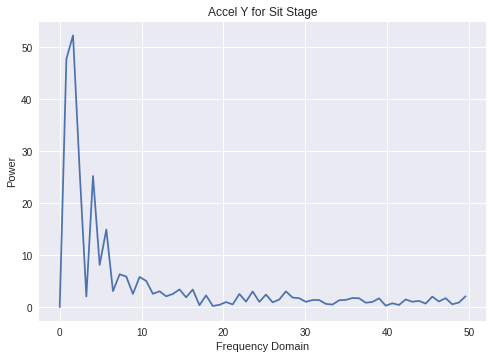

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_y = (last_df[last_df['Label'] == 'sit']['Y Axis'].values) - (last_df[last_df['Label'] == 'sit']['Y Axis'].values.mean())

yf = rfft(sit_y)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Y for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

**Z**

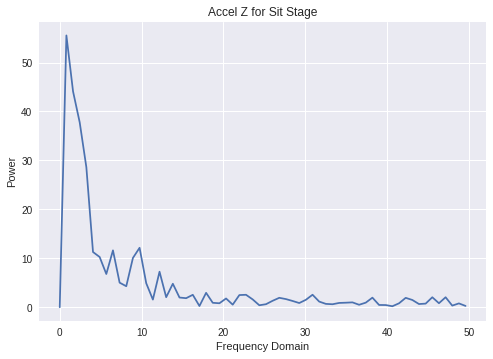

In [ ]:
# Number of samples in signal
N = last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_z = (last_df[last_df['Label'] == 'sit']['Z Axis'].values) - (last_df[last_df['Label'] == 'sit']['Z Axis'].values.mean())

yf = rfft(sit_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Sit Stage")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

--------------------------------------

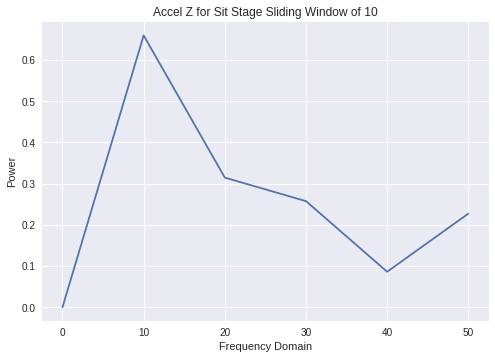

In [ ]:
# one sliding winodw would look like 

# Number of samples in signal
N = 10 #last_df[last_df['Label'] == 'sit'].shape[0]

SAMPLE_RATE = 100

sit_z = (last_df[last_df['Label'] == 'sit']['Z Axis'][:10].values) - (last_df[last_df['Label'] == 'sit']['Z Axis'][:10].values.mean())

yf = rfft(sit_z)
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.xlabel("Frequency Domain")
plt.ylabel("Power")

plt.title("Accel Z for Sit Stage Sliding Window of 10")

#plt.xlim(0, 10)

plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# most dominant frequency
max_freq = xf[np.argmax(np.abs(yf))]
print(max_freq)

10.0


In [ ]:
# max power
max_power = np.max(np.abs(yf))
print(max_power)

0.6599625286082403


In [ ]:
# mean weighted frequency
mean_freq = ((np.abs(yf).dot(xf))/ len(xf) )
print(mean_freq)

5.904179747060705


In [ ]:
abs(yf[0])

5.551115123125783e-17

In [ ]:
print(xf)

[ 0. 10. 20. 30. 40. 50.]


In [ ]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [ ]:
# skewness - checks if its normally distributed usually.  value greater than zero means that
# there is more weight in the right tail of the distribution and vice versa
skew_freq = skew(np.abs(yf))
print(skew_freq)

0.789273336459077


In [ ]:
#  It is a measure of the “tailedness” i.e. descriptor of shape of probability distribution of a real-valued random variable.
# In simple terms, one can say it is a measure of how heavy tail is compared to a normal distribution.

kurt_freq = kurtosis(np.abs(yf))
print(kurt_freq)

-0.2439934982897496


In [ ]:
list_id =  [
         

         [
          
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
          
         ],



         [
          
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
         [1, 2 , 3],
          
         ]


]

In [ ]:
cool = np.array(list_id)

In [ ]:
cool[:, : ,0:2]

array([[[1, 2],
        [1, 2],
        [1, 2],
        [1, 2]],

       [[1, 2],
        [1, 2],
        [1, 2],
        [1, 2]]])

<br>


<br>


<br>


-----------------------------------------------------

Now remove Sync from Start Service Ack & Sync from Stop Service Ack  as we dont actually need them, we will always have access to start time and finish time , we need to detect in between stages

In [ ]:
# remove start sync (usually just one anyways) 
last_df = last_df[last_df["Label"] != "Sync from Start Service Ack"]
print(last_df.shape)


# remove stop sync  
last_df = last_df[last_df["Label"] != "Sync from Stop Service Ack"]
print(last_df.shape)

(1848, 9)
(1733, 9)


------------------------------------------------------------

This is for getting start time of each phase 

In [ ]:
unique = last_df['Label'].unique()

In [ ]:
print(unique)

['Go' 'Walk 1' 'Turn 1' 'Walk 2' 'Turn 2' 'sit']


In [ ]:
first_time = []

for i in unique:

  unqiue_df = last_df[last_df['Label'] == i]

  # now want first one
  first_time.append(unqiue_df.iloc[0])


In [ ]:
first_times_df = pd.DataFrame(first_time)

In [ ]:
first_times_df

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label,Accel X,Accel Y,Accel Z
1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683,Go,0,0.032797,-0.407109,-0.450517
1970-01-01 00:04:38.480,2.784807e+11,-5.864355,-2.852618,7.296277,Walk 1,5,-0.654976,1.028487,0.230126
1970-01-01 00:04:41.270,2.812791e+11,-5.931116,-5.824238,0.200433,Turn 1,3,0.566870,1.268269,-0.784773
1970-01-01 00:04:47.220,2.872258e+11,-7.944579,-6.307134,-0.868494,Walk 2,6,-0.861964,0.495380,-1.208009
1970-01-01 00:04:49.270,2.892747e+11,-7.954758,-6.275999,1.839225,Turn 2,4,-0.790564,0.473325,0.922693
1970-01-01 00:04:53.560,2.935623e+11,-6.754254,-7.426057,0.049547,sit,7,-0.281300,-0.352764,-0.293914


In [ ]:
first_times_df.shape[0]

6

In [ ]:
first_times_df.index[0]

Timestamp('1970-01-01 00:04:37.460000')

In [ ]:
differences = []

# minus one since we have an i + 1 in loop 
for i in range(first_times_df.shape[0]-1):

  # time difference between phases
  diff = first_times_df.index[i+1] - first_times_df.index[i]

  differences.append(diff)



# print("Time Difference:  Go - Start Sync  (Test begins):" , differences[0])

print("\nTime Difference: Walk 1 - Go   (Getting Up) :", differences[0])

print("\nTime Difference: Turn 1 - Walk 1 (Walking 1) :", differences[1])

print("\nTime Difference: Walk 2 - Turn 1 (Turning 1) :", differences[2])

print("\nTime Difference: Turn 2 - Walk 2 (Walking 2) :", differences[3])

print("\nTime Difference: Sit - Turn 2 (Turning 2) :", differences[4])

# print("\nTime Difference: Stop Sync - Sit (Sitting) :", differences[6])


Time Difference: Walk 1 - Go   (Getting Up) : 0 days 00:00:01.020000

Time Difference: Turn 1 - Walk 1 (Walking 1) : 0 days 00:00:02.790000

Time Difference: Walk 2 - Turn 1 (Turning 1) : 0 days 00:00:05.950000

Time Difference: Turn 2 - Walk 2 (Walking 2) : 0 days 00:00:02.050000

Time Difference: Sit - Turn 2 (Turning 2) : 0 days 00:00:04.290000


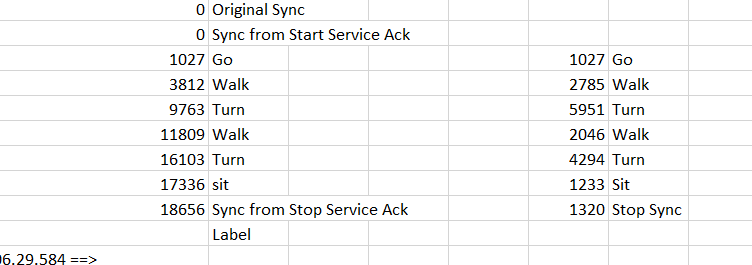-

Dont Expect to see any patterns here since this is just raw resampled X-accleration  compontent, but nice to visualize stages 

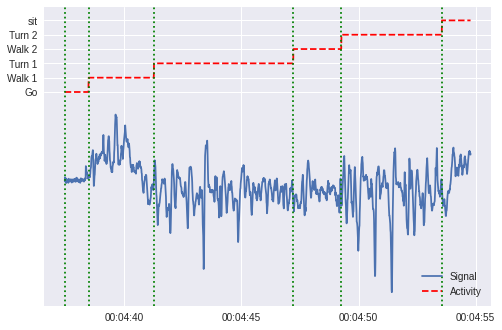

In [ ]:
plt.plot(last_df['X Axis'] , label= 'Signal')
plt.plot(last_df['Label']  , 'r--' , label='Activity' )

# green lines for start of phase
for i in range(first_times_df.shape[0]):
  plt.axvline(x = first_times_df.index[i] , color = 'g' , linestyle='dotted')



plt.legend()
plt.show()

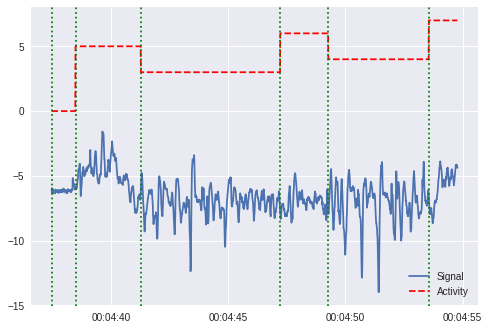

In [ ]:
plt.plot(last_df['X Axis'] , label= 'Signal')
plt.plot(last_df['Cat_Label']  , 'r--' , label='Activity' )

# green lines for start of phase 
for i in range(first_times_df.shape[0]):
  plt.axvline(x = first_times_df.index[i] , color = 'g' , linestyle='dotted')



plt.legend()
plt.show()

--------------------------------------


https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/

https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff

https://www.analyticsinsight.net/human-activity-prediction-using-machine-learning/

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

-

-----------------------------------------

# Sliding Window 


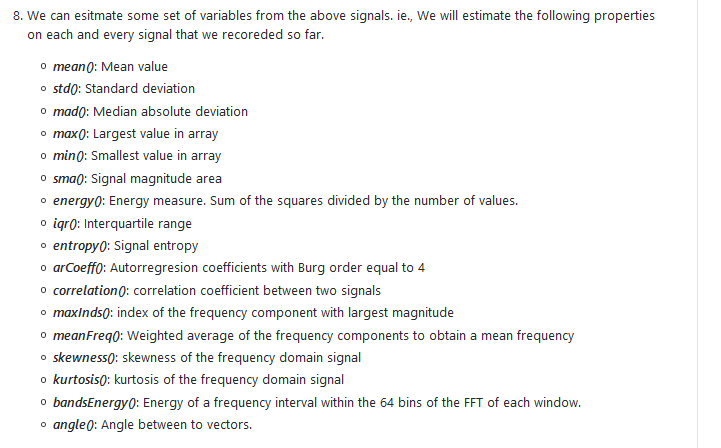

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

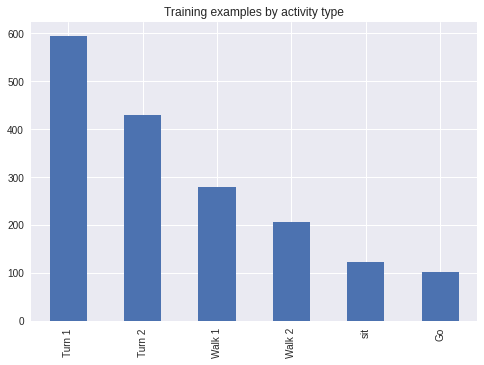

In [ ]:
last_df['Label'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [ ]:
# since evenly spaced in 0.01 seconds we can roughly approx how long each phase took 

last_df['Label'].value_counts()

Turn 1    595
Turn 2    429
Walk 1    279
Walk 2    205
sit       123
Go        102
Name: Label, dtype: int64

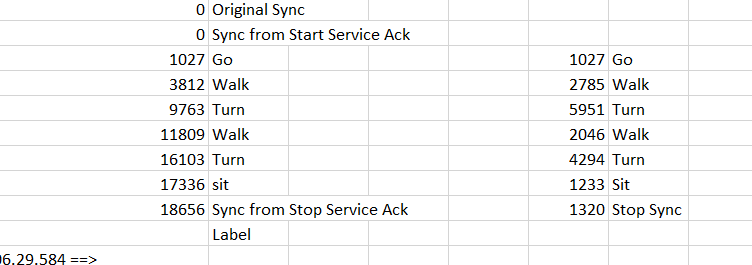-

# HAR Sliding Window 

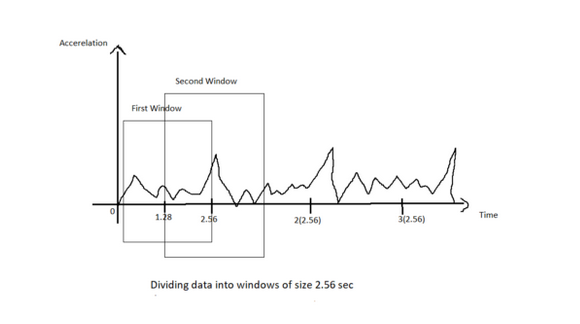

https://www.mdpi.com/1424-8220/19/7/1647/htm


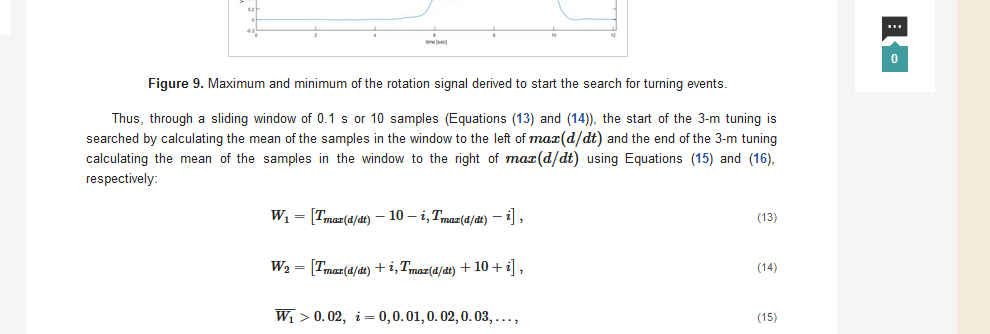

# Time Step 

Every time step of our index is 0.01 seconds.  Therefore To have 2.56 seconds , we would take 256 time steps of the dataframe as a segement. 



In [ ]:
last_df.shape

(1733, 9)

1849 / 256  = 7.22 segments 

Then for overlap we would have approx 6 segments. 

Some padding may be needed? 

https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-84.pdf

https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs/blob/master/human_activity_recognition.ipynb

https://dsp.stackexchange.com/questions/18649/signal-magnitude-area/18659

In [ ]:
# Signal Magnititude Area 
def sma(x , y , z):
  sum = 0

  for i in range(len(x)):
    sum += np.abs(x[i]) + np.abs(y[i]) + np.abs(z[i])

  return sum /len(x)


# Energy ( sum of squares divided by number of values)
def energy(x , y , z):
  sum_square = 0

  for i in range(len(x)):
    sum_square += (x[i])**2 + (y[i])**2 + (z[i])**2

  return sum_square /len(x)


In [ ]:
from scipy import stats

from scipy.stats import median_absolute_deviation
from sklearn.model_selection import train_test_split

In [ ]:
for i in range(0, 10, 2):

  print(i)

0
2
4
6
8


In [ ]:
# Just for X-acceleration as test 

N_TIME_STEPS = 256
N_FEATURES = 3
step = 128 # this will cause 50% overlap 

# hand-crafted features 

# mean 
mean_x = []
mean_y = []
mean_z = []

# std
std_x = []
std_y = []
std_z = []

# median absolute deviation
mad_x = []
mad_y = []
mad_z = []

# max value in segment/ array
max_x = []
max_y = []
max_z = []

# max value in segment/ array
min_x = []
min_y = []
min_z = []

#SMA (signal magnitude area)
sma_acc = [] 

# Energy ( sum of squares divided by number of values)
energy_acc = [] 

# Interquartile range 
iqr_x = []
iqr_y = []
iqr_z = []

# Signal Entropy 
entropy_x = []
entropy_y = []
entropy_z = []

# Correlation between 2 signals
corr_xy = []
corr_xz = []
corr_yz = []


# list to hold segments and labels 
segments = []
segments_2 = []
segments_3 = []

labels = []

for i in range(0, len(last_df) - N_TIME_STEPS, step):

    # replicating the 3 measurements 

    # Acceleration
    xs = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    ys = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
    zs = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments.append([xs, ys, zs])

    # Magnetmeter 
    xs_2 = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
    ys_2 = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    zs_2 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments_2.append([xs_2, ys_2, zs_2])

    # Gyro 
    xs_3 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]
    ys_3 = last_df['X Axis'].values[i: i + N_TIME_STEPS]
    zs_3 = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

    segments_3.append([xs_3, ys_3, zs_3])

    label = stats.mode(last_df['Label'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)

    ################# "hand crafted" features #################################

    # mean of segment
    x_mean_segment = np.mean(xs)
    y_mean_segment = np.mean(ys)
    z_mean_segment = np.mean(zs)

    mean_x.append(x_mean_segment)
    mean_y.append(y_mean_segment)
    mean_z.append(z_mean_segment)

    #std of segement 
    x_std_segment = np.std(xs)
    y_std_segment = np.std(ys)
    z_std_segment = np.std(zs)

    std_x.append(x_std_segment)
    std_y.append(y_std_segment)
    std_z.append(z_std_segment)

    # median absolute deviation 
    x_mad_segment = stats.median_absolute_deviation(xs)
    y_mad_segment = stats.median_absolute_deviation(ys)
    z_mad_segment = stats.median_absolute_deviation(zs)

    mad_x.append(x_mad_segment)
    mad_y.append(y_mad_segment)
    mad_z.append(z_mad_segment)

    # max value in segment/array
    x_max_segment = np.max(xs)
    y_max_segment = np.max(ys)
    z_max_segment = np.max(zs)

    max_x.append(x_max_segment)
    max_y.append(y_max_segment)
    max_z.append(z_max_segment)


    # max value in segment/array
    x_min_segment = np.min(xs)
    y_min_segment = np.min(ys)
    z_min_segment = np.min(zs)

    min_x.append(x_min_segment)
    min_y.append(y_min_segment)
    min_z.append(z_min_segment)

    # SMA (signal magnitude area)
    sma_segment = sma(xs , ys, zs)

    sma_acc.append(sma_segment)

    # Energy (sum of squares divided by number of values)
    energy_segment = energy(xs , ys, zs)

    energy_acc.append(energy_segment)

    # IQR 
    x_iqr_segment = stats.iqr(xs)
    y_iqr_segment = stats.iqr(ys)
    z_iqr_segment = stats.iqr(zs)

    iqr_x.append(x_iqr_segment)
    iqr_y.append(y_iqr_segment)
    iqr_z.append(z_iqr_segment)

    # Signal Entropy 
    x_entropy_segment = stats.entropy(xs)
    y_entropy_segment = stats.entropy(ys)
    z_entropy_segment = stats.entropy(zs)

    entropy_x.append(x_entropy_segment)
    entropy_y.append(y_entropy_segment)
    entropy_z.append(z_entropy_segment)

    # Correlation between 2 signals
    xy_corr_segment = np.corrcoef(xs,ys)
    xz_corr_segment = np.corrcoef(xs,zs)
    yz_corr_segment = np.corrcoef(ys,zs)

    # since this is a matrix with 1 on diagonal and off diagonal are equal
    # just access one of the off diagonal elements 
    corr_xy.append(xy_corr_segment[0][1])
    corr_xz.append(xz_corr_segment[0][1])
    corr_yz.append(yz_corr_segment[0][1])

-------------------------------------------

Would padding & using the full  be needed for final part of signal 

https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/

In [ ]:
N_TIME_STEPS = 256
N_FEATURES = 3
step = 128 # this will cause 50% overlap 

for i in range(0, len(last_df) - N_TIME_STEPS, step):

  print(i , i+258)

0 258
128 386
256 514
384 642
512 770
640 898
768 1026
896 1154
1024 1282
1152 1410
1280 1538
1408 1666


In [ ]:
N_TIME_STEPS = 10
N_FEATURES = 3
step = 5 # this will cause 50% overlap 

print(len(last_df))

for i in range(0, len(last_df)-step , step):

  print(i , i+step)

1733
0 5
5 10
10 15
15 20
20 25
25 30
30 35
35 40
40 45
45 50
50 55
55 60
60 65
65 70
70 75
75 80
80 85
85 90
90 95
95 100
100 105
105 110
110 115
115 120
120 125
125 130
130 135
135 140
140 145
145 150
150 155
155 160
160 165
165 170
170 175
175 180
180 185
185 190
190 195
195 200
200 205
205 210
210 215
215 220
220 225
225 230
230 235
235 240
240 245
245 250
250 255
255 260
260 265
265 270
270 275
275 280
280 285
285 290
290 295
295 300
300 305
305 310
310 315
315 320
320 325
325 330
330 335
335 340
340 345
345 350
350 355
355 360
360 365
365 370
370 375
375 380
380 385
385 390
390 395
395 400
400 405
405 410
410 415
415 420
420 425
425 430
430 435
435 440
440 445
445 450
450 455
455 460
460 465
465 470
470 475
475 480
480 485
485 490
490 495
495 500
500 505
505 510
510 515
515 520
520 525
525 530
530 535
535 540
540 545
545 550
550 555
555 560
560 565
565 570
570 575
575 580
580 585
585 590
590 595
595 600
600 605
605 610
610 615
615 620
620 625
625 630
630 635
635 640
640 645
645 6

-----------------------------------

In [ ]:
print(labels)

['Walk 1', 'Walk 1', 'Turn 1', 'Turn 1', 'Turn 1', 'Turn 1', 'Turn 1', 'Walk 2', 'Walk 2', 'Turn 2', 'Turn 2', 'Turn 2']


# Would a tighter sliding window be more of interest?  

-----------------------------------------------

# Hand Crafted Features 

In [ ]:
mean_x

[-5.115363523046875,
 -4.908196094921875,
 -6.269920823828125,
 -6.983695108984374,
 -7.02940920546875,
 -6.995301808203125,
 -7.05636896484375,
 -6.994208394140625,
 -6.9350714046875,
 -7.184877903125,
 -7.178843009375,
 -6.884483062109375]

In [ ]:
std_x

[1.1080095831285006,
 1.2892925498414085,
 1.4357045861877331,
 1.3791976498173897,
 1.3586697576628026,
 0.9007142223920112,
 0.6492080295906341,
 0.6874315114458838,
 1.156531296400829,
 1.7711906797192012,
 1.7103226218167815,
 1.2908495369667572]

In [ ]:
mad_x

[1.312818281879999,
 1.0057796055300003,
 1.3838351184000008,
 1.1929763138999998,
 0.9716031551100005,
 0.8554234315200001,
 0.7221551120700002,
 0.5838938405999994,
 0.8293466472899993,
 1.36674674493,
 1.1377166243099994,
 1.17000728166]

----------------------------------------------
Put handcraft into a dataframe , just some for example

In [ ]:
handcraft_features_segment_df = pd.DataFrame()

In [ ]:
handcraft_features_segment_df['Max Acceleration'] = max_x
handcraft_features_segment_df['Min Acceleration'] = min_x
handcraft_features_segment_df['Label_hand'] = labels

In [ ]:
handcraft_features_segment_df

,Max Acceleration,Min Acceleration,Label_hand
0,-1.574576,-6.563701,Walk 1
1,-1.574576,-7.865394,Walk 1
2,-2.331252,-9.858799,Turn 1
3,-3.398233,-12.364438,Turn 1
4,-3.398233,-12.364438,Turn 1
5,-5.101092,-10.484797,Turn 1
6,-5.782774,-8.590935,Turn 1
7,-4.787344,-8.618328,Walk 2
8,-4.466861,-11.089689,Walk 2
9,-4.184099,-13.985268,Turn 2


-----------------------------------------------------------

# Segment Signals 

In [ ]:
last_df.head(5)

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label,Accel X,Accel Y,Accel Z
Time,,,,,,,,,
1970-01-01 00:04:37.460,2.774615e+11,-6.219566,-2.746788,7.245683,Go,0,0.032797,-0.407109,-0.450517
1970-01-01 00:04:37.470,2.774715e+11,-5.949977,-2.938539,7.375313,Go,0,-0.024964,-0.414262,-0.439629
1970-01-01 00:04:37.480,2.774815e+11,-6.266419,-2.756069,7.297475,Go,0,-0.057499,-0.413915,-0.424911
1970-01-01 00:04:37.490,2.774915e+11,-6.055358,-2.788551,7.098239,Go,0,-0.071265,-0.405789,-0.421900
1970-01-01 00:04:37.500,2.775015e+11,-6.041287,-2.699786,7.265292,Go,0,-0.083109,-0.399448,-0.438040


In [ ]:
last_df.tail(5)

,Event Time (ns),X Axis,Y Axis,Z Axis,Label,Cat_Label,Accel X,Accel Y,Accel Z
Time,,,,,,,,,
1970-01-01 00:04:54.740,2.947416e+11,-4.120332,-8.546926,0.518821,sit,7,1.430772,-0.709356,-0.433646
1970-01-01 00:04:54.750,2.947516e+11,-4.354445,-8.362210,0.674797,sit,7,1.404140,-0.740698,-0.516550
1970-01-01 00:04:54.760,2.947616e+11,-4.328549,-8.383766,0.439037,sit,7,1.369718,-0.810316,-0.550884
1970-01-01 00:04:54.770,2.947716e+11,-4.260740,-8.470884,0.621657,sit,7,1.339887,-0.895471,-0.563833
1970-01-01 00:04:54.780,2.947816e+11,-4.373754,-8.702752,0.498912,sit,7,1.326162,-0.974726,-0.567655


In [ ]:
print(np.array(segments).shape)
print(np.array(segments_2).shape)
print(np.array(segments_3).shape)

(12, 3, 256)
(12, 3, 256)
(12, 3, 256)


In [ ]:
# X-Axis
(segments[-1][0])

array([ -4.247717 ,  -4.2505608,  -3.9303768,  -4.203708 ,  -5.1774335,
        -5.9362054,  -6.0680814,  -6.4545774,  -6.4273343,  -6.4174547,
        -6.343958 ,  -6.439459 ,  -6.4050307,  -6.336922 ,  -6.443351 ,
        -6.2848306,  -6.507717 ,  -6.4770308,  -6.6584535,  -6.5720835,
        -6.5360084,  -6.6547112,  -6.5225363,  -6.611152 ,  -6.344257 ,
        -6.577023 ,  -6.656657 ,  -6.6797094,  -6.7710195,  -6.897806 ,
        -6.873556 ,  -6.9024463,  -7.0135155,  -7.0186048,  -7.3112464,
        -7.329059 ,  -7.6029897,  -7.407047 ,  -7.6904078,  -7.9442797,
        -7.7731857,  -7.63637  ,  -6.0905347,  -5.604196 ,  -6.2848306,
        -6.595884 ,  -6.496191 ,  -6.4593678,  -6.715635 ,  -7.484436 ,
        -8.343201 ,  -8.931327 ,  -9.207802 ,  -9.513018 ,  -9.529184 ,
        -9.549392 ,  -9.89203  ,  -9.959539 ,  -9.579928 ,  -8.745414 ,
        -7.9306583,  -6.581514 ,  -5.7107744,  -4.6493316,  -4.9076943,
        -5.6377263,  -6.600374 ,  -6.7566495,  -6.5445404,  -6.2

In [ ]:
# Y-Axis
(segments[-1][1])

array([ -5.5121374,  -6.1171794,  -6.742878 ,  -7.8920383,  -8.446036 ,
        -8.25219  ,  -8.148754 ,  -7.986941 ,  -8.196655 ,  -7.9267664,
        -7.7079215,  -7.758067 ,  -7.758217 ,  -7.6679544,  -7.629335 ,
        -7.7416015,  -7.781119 ,  -7.808662 ,  -7.696096 ,  -7.548952 ,
        -7.3356457,  -6.9754944,  -6.946006 ,  -6.701564 ,  -6.6451316,
        -6.2147765,  -6.147566 ,  -5.974526 ,  -5.975125 ,  -5.753735 ,
        -5.6510487,  -5.5690193,  -5.4510646,  -5.243596 ,  -4.9157777,
        -4.827611 ,  -4.561165 ,  -4.6758265,  -4.715494 ,  -4.678671 ,
        -4.9951124,  -5.026996 ,  -6.5614552,  -8.040529 ,  -8.222851 ,
        -7.265741 ,  -6.127208 ,  -5.3587065,  -5.531747 ,  -5.965395 ,
        -6.396199 ,  -6.7708697,  -6.811735 ,  -6.42449  ,  -6.2044477,
        -6.4608645,  -6.801706 ,  -7.447463 ,  -7.9137435,  -8.498577 ,
        -8.78568  ,  -9.052725 ,  -9.002728 ,  -9.125025 ,  -8.376132 ,
        -6.8514023,  -5.4780083,  -5.1308804,  -4.7773156,  -4.6

In [ ]:
# Z- Axis
segments[-1][2]

array([ 8.52177860e-01,  9.09508650e-01,  1.92903850e+00,  3.32219150e+00,
        2.89198610e+00,  1.86152890e+00,  1.40108640e+00,  1.29390930e+00,
        9.75072300e-01,  9.10855900e-01,  7.14464250e-01,  8.19246350e-01,
        7.31678500e-01,  8.97533600e-01,  8.64302700e-01,  9.12203100e-01,
        7.55329300e-01,  5.78247550e-01,  3.76616840e-01,  5.47860740e-01,
        4.30953830e-01,  2.25580900e-01,  2.46237950e-01,  2.17048650e-01,
        2.28724360e-01,  1.32474510e-01,  5.49357600e-02, -2.58213040e-01,
       -1.93098460e-01,  7.63412470e-03, -1.10021210e-01,  5.86779800e-02,
        4.93972800e-02,  2.72433460e-01,  5.64476200e-01,  1.01444040e+00,
        1.04602480e+00,  9.57109700e-01,  1.06698120e+00,  1.13868210e+00,
        1.60211840e+00,  2.47495340e+00,  8.68793300e+00,  1.19812350e+01,
        7.76615000e+00,  5.85761900e+00,  4.57209200e+00,  3.20109320e+00,
        2.62179800e+00,  2.41238330e+00,  2.38334370e+00,  2.50459170e+00,
        2.50369360e+00,  

--------------------------------------------

In [ ]:
# set up an array of size  256 (n_time_steps )  rows and 3 cols [ X , Y , Z ]

array_setup_checker =  [ [ [ None for y in range( 3 ) ] for x in range( 256 ) ] for z in range(13) ]

array_setup_checker_22 =  [ [ None for y in range( 3 ) ] for x in range( 256 ) ]

np.array(array_setup_checker).shape

(13, 256, 3)

In [ ]:
# Should be first element of each has value

for window in range(np.array(array_setup_checker).shape[0]):

  for i in range(np.array(array_setup_checker).shape[1]):
    array_setup_checker[window][i][0] = segments[window][0][i]
    array_setup_checker[window][i][1] = segments[window][1][i]
    array_setup_checker[window][i][2] = segments[window][2][i]

IndexError: ignored

In [ ]:
np.array(array_setup_checker).shape

In [ ]:
array_setup_checker

In [ ]:
# join them all together 
segment_all = np.concatenate((segments , segments_2 , segments_3 ))

In [ ]:
segment_all.shape

In [ ]:
segment_all[0][1][0]

########################## Need to look into reshape #########################

In [ ]:
# set up an array of size  50 (n_time_steps )  rows and 9 cols [ X , Y , Z ]


array_setup_checker =  [ [ [ None for y in range( 9 ) ]  for x in range( 256 ) ] for z in range( 13) ]

np.array(array_setup_checker).shape


In [ ]:
for window in range(np.array(array_setup_checker).shape[0]):

  for segment in range(np.array(array_setup_checker).shape[1]):

    # col 1 
    array_setup_checker[window][segment][0] = segment_all[window][segment]

    # col 2
    array_setup_checker[window][segment][1] = segment_all[window]

    # col 3 
    array_setup_checker[window][segment][2] = segment_all[window]



In [ ]:
# 

In [ ]:
np.array(segment_all).shape

In [ ]:
reshaped_segments.shape

In [ ]:
reshaped_segments[0][0][:3]

--------------------------------------------

Now just to check how muliple excel files will be added together 

In [ ]:
# imaginery second persons data (just a copy of original though just for sake of ease )

reshaped_segments_2 = reshaped_segments
labels_2 = labels

In [ ]:
# want a shape of 26 , 256, 9 
# this would be when reading in both excel files and adding together

all_together_reshaped_segments = np.concatenate((reshaped_segments , reshaped_segments_2))

In [ ]:
all_together_reshaped_segments.shape

In [ ]:
# can see the 9 signals - x acc y acc z acc etc... 

reshaped_segments[0][0]

In [ ]:
# this would be when reading in both excel files and adding together for labels
all_together_labels = np.concatenate((labels , labels_2))

In [ ]:
all_together_labels.shape

In [ ]:
labels[0]

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(
#         reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)



----------------------------------------
Looking into padding series , so will have a constant size but also cover each part of the signal 


In [ ]:
# Padding issue 

N_TIME_STEPS = 256
step = 128

# list to hold segments and labels 
segments_test_pad = []

for i in range(0, len(last_df) , step):

  print(f"-------------------{i} TO {i + N_TIME_STEPS}--------------------")

  xs = last_df['X Axis'].values[i: i + N_TIME_STEPS]
  ys = last_df['Y Axis'].values[i: i + N_TIME_STEPS]
  zs = last_df['Z Axis'].values[i: i + N_TIME_STEPS]

  
  if  (i + step >= len(last_df)) or (i + N_TIME_STEPS >= len(last_df) ):
    print('Hit IF Statement, all signal covered')

    xs = np.zeros(N_TIME_STEPS)
    ys = np.zeros(N_TIME_STEPS)
    zs = np.zeros(N_TIME_STEPS)

    x = last_df['X Axis'].values[i::]
    y = last_df['Y Axis'].values[i::]
    z = last_df['Z Axis'].values[i::]

    xs[:len(x)] = x
    ys[:len(y)] = y
    zs[:len(z)] = z

    print(len(xs))
    segments_test_pad.append([xs, ys, zs])


  else:
    # fine to just append 
    print(len(xs))
    segments_test_pad.append([xs, ys, zs])


In [ ]:
np.array(segments_test_pad).shape

In [ ]:
reshaped_segments_test = np.asarray(segments_test_pad, dtype= np.float32).reshape(-1, N_TIME_STEPS, 3)

print(reshaped_segments_test.shape)

_

_

_

_

_

_

_

_

_

-------------------------------------------------

# Function for find Fc - Dont think its needed but just keeping incase  

# Function to pick fc by min error of fc val - 9.81 ( which is gravity )

In [ ]:

def find_fc( x , y , z,  start = 0.00001 , end= 5 , step = 0.01 , fs = 100 , tol = 0.01 ):

  index = 0 
  vals = []
  diffs = []
  tol = tol
  stds_list = []

  # set best fc as something really high so always will have something better 
  best_fc = np.inf
  best_diff = np.inf
  best_std = np.inf

  # setting sample frequency
  fs = fs 

  # cut off frequency range
  fc = np.arange(start, end , step)

  # this  is defining the accceleration data 
  x = x 
  y = y 
  z = z 

  for val in fc:

    fc = val
    w = fc/(fs/2)
    b,a = signal.butter(3, w, 'low')

    x_filtered = signal.filtfilt(b,a,x)
    y_filtered = signal.filtfilt(b,a,y)
    z_filtered = signal.filtfilt(b,a,z)

    x_squared = x_filtered**2
    y_squared = y_filtered**2
    z_squared = z_filtered**2

    total_squared = x_squared + y_squared  + z_squared 

    # want the mean of this to keep gravity constant throughout the trial 
    value_total_acc = np.sqrt(np.mean(total_squared))

    # calculating std 
    std_total =  np.std(total_squared)

    stds_list.append(std_total)
    vals.append(value_total_acc)

    diff =  value_total_acc - 9.81 

    diffs.append(diff)

    index += 1

    # we want to minimize this as close to zero, so include absolute val
    if ( abs(diff) < abs(best_diff)  and  abs(std_total) <= 1  )  or  (abs(diff) == abs(best_diff) and abs(std_total) < abs(best_std) ) :
      best_diff = diff
      best_std = std_total
      best_fc = val 
      index_val = index
      best_x = x_filtered 
      best_y = y_filtered
      best_z = z_filtered

  # Want some sort of error message, if the value is within tolerance 
  if best_diff > tol:
    print(f"Please widen start and stop range, current best value {value_total_acc} > tolerance {tol}")
    
  else:
    return best_fc, best_diff , best_std  , stds_list,  vals , diffs , index_val , best_x ,best_y , best_z 

In [ ]:
#fc_test = find_fc(raw_acc_1_resampled['X Axis'] , raw_acc_1_resampled['Y Axis'] , raw_acc_1_resampled['Z Axis'] , start = 3 , end= 4 ,step = 0.1 , tol = 0.0000000001 )


In [ ]:
#fc_1 = find_fc(x1_median_20hz, y1_median_20hz, z1_median_20hz, start = 0.01 , end= 0.8 ,step = 0.001 )


------------------------------

https://stackoverflow.com/questions/37996295/how-to-save-numpy-array-into-computer-for-later-use-in-python

https://pythonexamples.org/pandas-write-dataframe-to-excel-sheet/

https://www.nature.com/articles/s41467-020-15086-2#citeas

https://github.com/negargolestani/Activity_Detection

---------------------
State of Art 

1)
https://www.sciencedirect.com/science/article/pii/S0957417418302136


2)
https://www.sciencedirect.com/science/article/pii/S1877050914008643

3)
https://www.sciencedirect.com/science/article/pii/S1877050919310166

4)
https://arxiv.org/pdf/1806.05226.pdf


